# Fair Conformal Predictions for Applications in Medical Imaging

Results for AAAI 2022

* [Paper](https://arxiv.org/abs/2109.04392)
* [Data](https://github.com/mattgroh/fitzpatrick17k)
* [Tutorial](https://arxiv.org/abs/2107.07511)

In [1]:
from src import platt
from src import uncertainty
from src import conformal
from src import distances
from src import metrics
from src import utils

import importlib
importlib.reload(metrics)
importlib.reload(platt)
importlib.reload(uncertainty)
importlib.reload(conformal)
importlib.reload(utils)
importlib.reload(distances)

import collections, itertools, json, os, pathlib, sys

import PIL
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"

import torch
import math
print('scipy\t', scipy.__version__)
print('pytorch\t', torch.__version__)
print('pandas\t', pd.__version__)
print('numpy\t', np.__version__)
print('python\t', sys.version)
np.random.seed(0)

scipy	 1.9.1
pytorch	 1.13.1
pandas	 1.4.4
numpy	 1.21.5
python	 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


## Path to label file

In [2]:
label_csv = 'skin-info.csv'
skin_df = pd.read_csv(label_csv)
skin_df.head()

,Unnamed: 0.1,Unnamed: 0,md5hash,fitzpatrick,raw_label,nine_partition_label,three_partition_label,qc,url,url_alphanum,image,label,source
0,0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,5e82a45bc5d78bd24ae9202d194423f8.jpg,4,0
1,1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,fa2911a9b13b6f8af79cb700937cc14f.jpg,4,0
2,2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,d2bac3c9e4499032ca8e9b07c7d3bc40.jpg,0,0
3,3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0a94359e7eaacd7178e06b2823777789.jpg,4,0
4,4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,a39ec3b1f22c08a421fa20535e037bba.jpg,4,0


## Save figures to here

In [3]:
save_dir = 'figures/'
fig_dir = pathlib.Path(save_dir)
fig_dir.mkdir(exist_ok=True)

## Plot class distribution 

In [4]:
neo_df = skin_df.query('three_partition_label == "non-neoplastic"')
ben_df = skin_df.query('three_partition_label == "benign"')
mal_df = skin_df.query('three_partition_label == "malignant"')

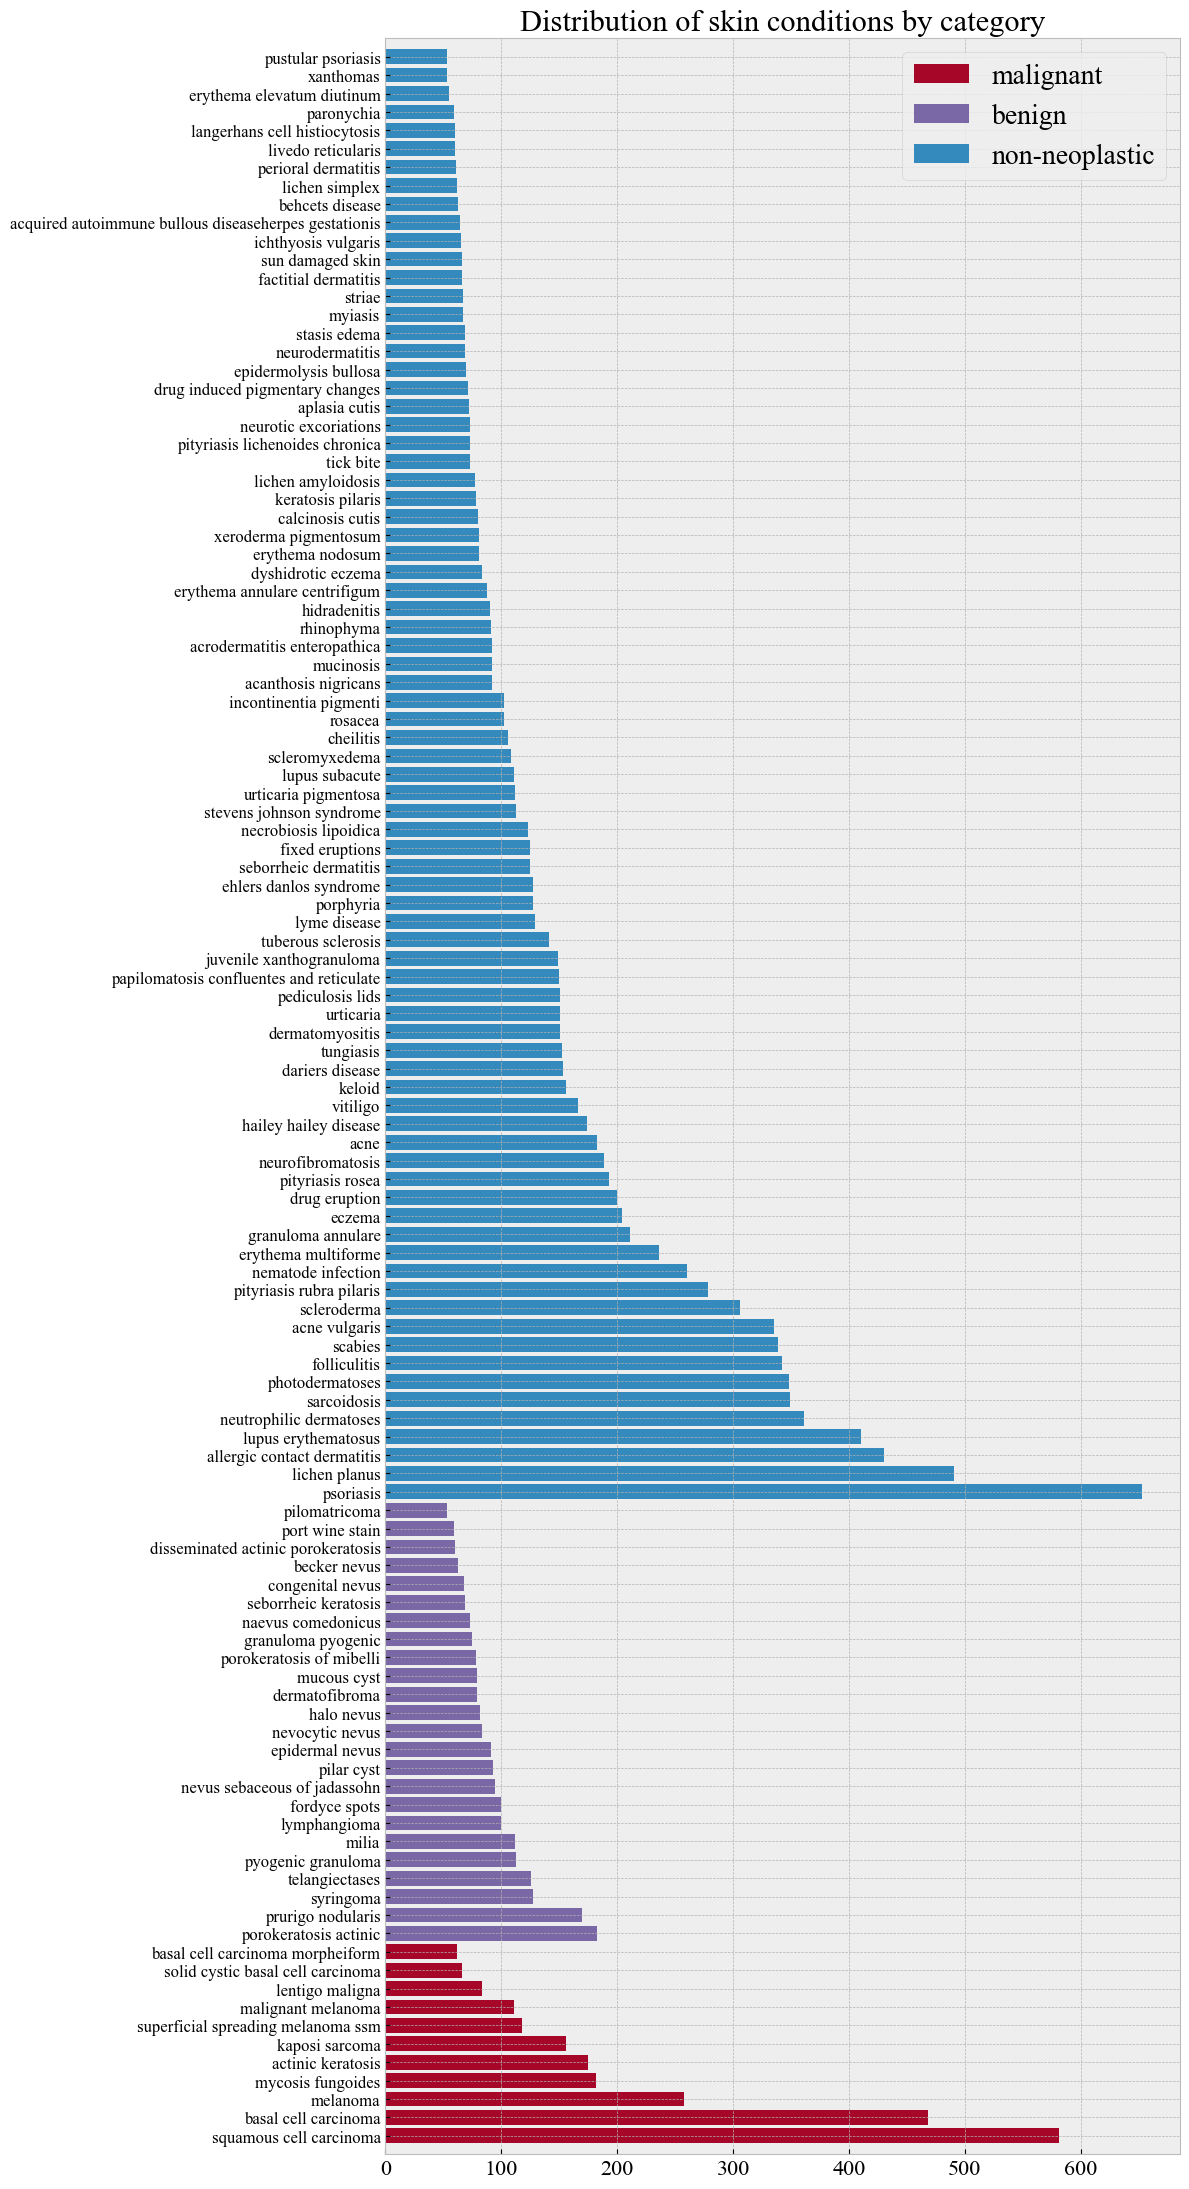

In [5]:
plt.figure(figsize=(12, 22))
plt.title('Distribution of skin conditions by category', fontsize=22)
plt.ylim(-1, 114)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
# plt.ylabel('Skin condition', fontsize=24)
plt.barh(*list(zip(*mal_df.raw_label.value_counts().items())), color='C1', label='malignant')
plt.barh(*list(zip(*ben_df.raw_label.value_counts().items())), color='C2', label='benign')
plt.barh(*list(zip(*neo_df.raw_label.value_counts().items())), color='C0', label='non-neoplastic')
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(fig_dir / 'bar-class-distribution.png')
plt.show()

2023-05-05 08:10:54,922 - maxp pruned
2023-05-05 08:10:54,926 - LTSH dropped
2023-05-05 08:10:54,932 - cmap pruned
2023-05-05 08:10:54,946 - kern dropped
2023-05-05 08:10:54,949 - post pruned
2023-05-05 08:10:54,961 - PCLT dropped
2023-05-05 08:10:55,003 - GPOS pruned
2023-05-05 08:10:55,031 - GSUB pruned
2023-05-05 08:10:55,031 - JSTF dropped
2023-05-05 08:10:55,039 - DSIG dropped
2023-05-05 08:10:55,044 - name pruned
2023-05-05 08:10:55,381 - glyf pruned
2023-05-05 08:10:55,390 - Added gid0 to subset
2023-05-05 08:10:55,394 - Added first four glyphs to subset
2023-05-05 08:10:55,398 - Closing glyph list over 'GSUB': 29 glyphs before
2023-05-05 08:10:55,402 - Glyph names: ['.notdef', 'a', 'b', 'c', 'e', 'f', 'five', 'four', 'g', 'glyph00001', 'glyph00002', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'z', 'zero']
2023-05-05 08:10:55,410 - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 68, 69, 70, 72, 73, 74, 76, 78, 79, 

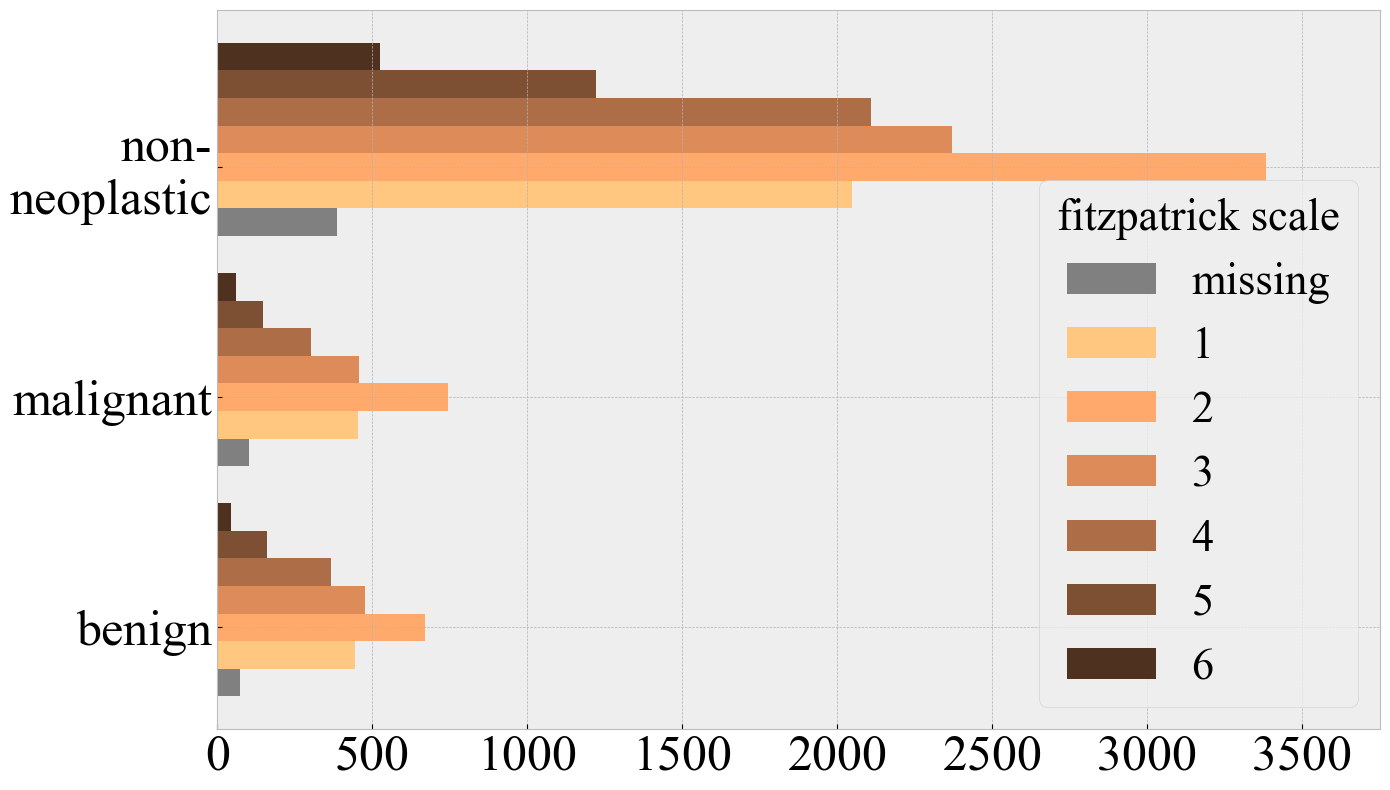

In [6]:
import matplotlib.pyplot as plt
import numpy as np

SKIN_COLORS = plt.cm.copper_r(np.linspace(0, 0.75, 6))
fontsize=24

classes = ['benign', 'malignant', 'non-\nneoplastic']

x = np.arange(len(classes))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars = [
    ax.barh(
        x + (-2 if i == -1 else i - 2) * width, 
        list(map(
            lambda x: x[1],
            sorted(skin_df.query(f'fitzpatrick == @i').three_partition_label.value_counts(sort=False).items())
        )),
        width, 
        label='missing' if i == -1 else str(i), 
        color='gray' if i == -1 else SKIN_COLORS[i-1],
    )
    for i in [-1] + list(range(1, 7))

]

# ax.set_title('Distribution of disease type by skin tone', fontsize=fontsize + 16)
ax.set_xlim(0, 3750)
ax.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
for t in ax.get_xticklabels():    #get_xticklabels will get you the label objects, same for y
    t.set_fontsize(fontsize + 12)
ax.set_yticks(x, classes, fontsize=fontsize + 12)
# ax.set_ylabel('Skin condition type', fontsize=fontsize + 8)

ax.legend(
    title='fitzpatrick scale', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize + 8,
    },
    fontsize=fontsize + 8,
    loc='lower right',
)

# for bar in bars:
    # ax.bar_label(bar, padding=4, fontsize=fontsize+6)
    
fig.tight_layout()
plt.savefig(fig_dir / 'fitz-subgroup-class-dist.pdf')
plt.show()

## Disease prevalence by skin type

In [7]:
skin_type_1 = skin_df.query('fitzpatrick == 1').three_partition_label.value_counts()
skin_type_2 = skin_df.query('fitzpatrick == 2').three_partition_label.value_counts()
skin_type_3 = skin_df.query('fitzpatrick == 3').three_partition_label.value_counts()
skin_type_4 = skin_df.query('fitzpatrick == 4').three_partition_label.value_counts()
skin_type_5 = skin_df.query('fitzpatrick == 5').three_partition_label.value_counts()
skin_type_6 = skin_df.query('fitzpatrick == 6').three_partition_label.value_counts()
skin_type_missing = skin_df.query('fitzpatrick == -1').three_partition_label.value_counts()
skin_type_all = skin_df.three_partition_label.value_counts()

def prevalence(group):
    total = group.sum()
    neo = group['non-neoplastic'] / total
    ben = group['benign'] / total
    mal = group['malignant'] / total
    print(f'Non-neoplastic\t{neo:.2%}')
    print(f'Benign\t\t{ben:.2%}')
    print(f'Malignant\t{mal:.2%}')
    print(f'Count\t\t{total:.2f}')
    print()
    
print('1'.center(20, '-')); prevalence(skin_type_1)
print('2'.center(20, '-')); prevalence(skin_type_2)
print('3'.center(20, '-')); prevalence(skin_type_3)
print('4'.center(20, '-')); prevalence(skin_type_4)
print('5'.center(20, '-')); prevalence(skin_type_5)
print('6'.center(20, '-')); prevalence(skin_type_6)
print('Missing'.center(20, '-')); prevalence(skin_type_missing)
print('All'.center(20, '-')); prevalence(skin_type_all)

---------1----------
Non-neoplastic	69.57%
Benign		15.03%
Malignant	15.40%
Count		2941.00

---------2----------
Non-neoplastic	70.54%
Benign		13.99%
Malignant	15.47%
Count		4796.00

---------3----------
Non-neoplastic	71.78%
Benign		14.40%
Malignant	13.82%
Count		3299.00

---------4----------
Non-neoplastic	75.94%
Benign		13.22%
Malignant	10.84%
Count		2776.00

---------5----------
Non-neoplastic	80.03%
Benign		10.41%
Malignant	9.56%
Count		1527.00

---------6----------
Non-neoplastic	83.44%
Benign		7.01%
Malignant	9.55%
Count		628.00

------Missing-------
Non-neoplastic	68.86%
Benign		12.99%
Malignant	18.15%
Count		562.00

--------All---------
Non-neoplastic	72.83%
Benign		13.50%
Malignant	13.67%
Count		16529.00



## Prediction results 

* Resnet models initialized with different random seed (5 runs)
* Train each model on fitzpatrick dataset for skin lesion classification (114 classes)
* MC-dropout for epistemic uncertainty (30 samples)

In [8]:
from sklearn.model_selection import train_test_split

#best run so far, with test_size = 0.4
df = pd.read_csv("results_50_random_holdout_val_resnet_newlayer_lowdropout_alllogits.csv")
df.loc[df['fitzpatrick_scale'] == -1, 'fitzpatrick_scale'] = 0

#df[['label', 'fitzpatrick_scale']].values
valid_df, test_df = train_test_split(df, test_size=0.4, stratify=df['fitzpatrick_scale'])

#print(len(valid_df))
#print(len(test_df))
#print(len(test_df[test_df['fitzpatrick_scale'] == 6]))
#print(len(valid_df[valid_df['fitzpatrick_scale'] == 6]))

In [9]:
label_map = dict(enumerate(sorted(skin_df.raw_label.unique())))
reversed_label_map = dict(zip(label_map.values(), label_map.keys()))
label_map

{0: 'acanthosis nigricans',
 1: 'acne',
 2: 'acne vulgaris',
 3: 'acquired autoimmune bullous diseaseherpes gestationis',
 4: 'acrodermatitis enteropathica',
 5: 'actinic keratosis',
 6: 'allergic contact dermatitis',
 7: 'aplasia cutis',
 8: 'basal cell carcinoma',
 9: 'basal cell carcinoma morpheiform',
 10: 'becker nevus',
 11: 'behcets disease',
 12: 'calcinosis cutis',
 13: 'cheilitis',
 14: 'congenital nevus',
 15: 'dariers disease',
 16: 'dermatofibroma',
 17: 'dermatomyositis',
 18: 'disseminated actinic porokeratosis',
 19: 'drug eruption',
 20: 'drug induced pigmentary changes',
 21: 'dyshidrotic eczema',
 22: 'eczema',
 23: 'ehlers danlos syndrome',
 24: 'epidermal nevus',
 25: 'epidermolysis bullosa',
 26: 'erythema annulare centrifigum',
 27: 'erythema elevatum diutinum',
 28: 'erythema multiforme',
 29: 'erythema nodosum',
 30: 'factitial dermatitis',
 31: 'fixed eruptions',
 32: 'folliculitis',
 33: 'fordyce spots',
 34: 'granuloma annulare',
 35: 'granuloma pyogenic',
 

In [10]:
accuracy = []
correct = 0

for i, row in test_df.iterrows():
    label = row.label

    #pred = np.argmax([c for c in row[1:]])
    pred = row.d1
    if label == pred: correct += 1
accuracy.append(correct / len(test_df))

top3_accuracy = []
top3_correct = 0

for i, row in test_df.iterrows():
    label = row.label

    #pred = np.argmax([c for c in row[1:]])
    pred = row.d1
    if label == row.d1 or label == row.d2 or label == row.d3: 
        top3_correct += 1
top3_accuracy.append(top3_correct / len(test_df))

In [11]:
print(f'average accuracy: {np.mean(accuracy):.2f} +/- {np.std(accuracy):.2f}')
print(f'average accuracy in top 3: {np.mean(top3_accuracy):.2f} +/- {np.std(top3_accuracy):.2f}')

average accuracy: 0.18 +/- 0.00
average accuracy in top 3: 0.34 +/- 0.00


In [12]:
# Percent of entries with top guesses greater than 0.2
print(f'Percent of entries with top guesses greater than 0.2: {len(test_df[test_df["p1"] > 0.2]) / len(test_df)}')

Percent of entries with top guesses greater than 0.2: 0.3203266787658802


In [13]:
# number of  classses
C = 114
#C = 3

def get_logits(row):
    return np.array([row[f'logit_class_{c}'] for c in range(C)]).tolist()
    # all_pred = [row[f'pred_{c}'] for c in range(C)]
    # return np.array(all_pred).mean(1).tolist()

valid_df['logits'] = valid_df.apply(lambda row: get_logits(row), axis=1)
test_df['logits'] = test_df.apply(lambda row: get_logits(row), axis=1)

test_df

,hasher,label,fitzpatrick_scale,prediction_probability,prediction,d1,d2,d3,p1,p2,...,logit_class_105,logit_class_106,logit_class_107,logit_class_108,logit_class_109,logit_class_110,logit_class_111,logit_class_112,logit_class_113,logits
3179,b081ebda9de46a8163d89a994c6a31bb,95,2,-1.849420,45,45,7,95,0.157328,0.121636,...,-5.811264,-6.456911,-6.757826,-9.232710,-7.316401,-8.222038,-7.209938,-6.168791,-5.665412,"[-5.516622066497803, -4.348148345947266, -7.05..."
1588,a9f10b773cc99b071bc6b49851d8525e,47,4,-1.332994,29,29,47,63,0.263687,0.172492,...,-6.546235,-4.476027,-6.811543,-12.079445,-5.311297,-5.497814,-5.549475,-6.123554,-5.304317,"[-5.171371936798096, -9.73967742919922, -9.928..."
8016,92f495dced3596eb3c88056d7741eee4,58,3,-2.053668,104,104,70,57,0.128264,0.106793,...,-5.096591,-6.478436,-5.646397,-4.394936,-7.488333,-8.260815,-3.772299,-6.571271,-9.174352,"[-4.892233848571777, -5.754891872406006, -6.47..."
2990,b2bc627e5b64a70892f1aa72793ee642,93,1,-2.825036,74,74,90,105,0.059307,0.049190,...,-3.242987,-5.166386,-3.839451,-9.414678,-4.631436,-3.862220,-4.396438,-3.695948,-3.710561,"[-5.416051864624023, -3.8447635173797607, -4.2..."
299,d2e96d346577a155b0125dda66b16395,8,1,-2.311013,16,16,77,57,0.099161,0.066641,...,-4.314842,-3.664660,-6.269707,-9.346380,-5.253149,-6.153704,-7.696779,-4.346887,-8.597694,"[-7.0704345703125, -4.549153804779053, -5.8298..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,dea8f4fc4ec290d3bc9b5b0977bdf880,37,4,-2.300128,109,109,17,110,0.100246,0.063710,...,-3.289815,-7.055121,-3.078442,-9.625591,-2.300128,-3.072476,-4.159574,-4.572710,-4.297649,"[-6.38683557510376, -3.9882209300994873, -3.60..."
1948,065ec3635735cc338f28cc5c24513bad,6,1,-1.518313,74,74,13,84,0.219081,0.160199,...,-3.718521,-5.974751,-7.094806,-13.003427,-3.849353,-6.438411,-5.490499,-6.086576,-11.245425,"[-8.177717208862305, -5.942079544067383, -6.24..."
3175,8c0604e79e52075793ab338849a441c1,45,2,-2.100903,57,57,24,110,0.122346,0.055773,...,-3.991789,-5.981121,-4.657233,-7.197781,-3.414215,-3.043854,-4.646449,-5.779479,-8.374490,"[-5.444023132324219, -3.970546722412109, -4.54..."
6161,7a1fc4aba94408a5d067ed69533b834f,18,3,-2.218099,18,18,101,44,0.108816,0.073626,...,-4.425725,-4.811052,-5.812515,-10.526475,-3.995702,-4.247717,-5.306303,-4.778633,-6.207654,"[-4.629403114318848, -4.053958892822266, -5.28..."


### Apply platt scaling

In [14]:
# We hit an error here, I believe because we reduced our class size down to 3 (aka top 3)
# When we go to index into logits, that index doesn't exist.

# learn temperature weight using validation set
T = platt.get_platt_scaling(valid_df.label.values, [x for x in valid_df.logits.values])
valid_logits = torch.tensor([x for x in valid_df.logits.values]) 
valid_df['scores'] = torch.softmax(valid_logits / T, axis=1).tolist()

# apply on test set
test_logits = torch.tensor([x for x in test_df.logits.values]) 
test_df['scores'] = torch.softmax(test_logits / T, axis=1).tolist()


### Subgroups

In [15]:
#A = list(reversed(range(len(df.fitzpatrick_scale.unique()))))
A = [6, 5, 4, 3, 2, 1, 0]
A

[6, 5, 4, 3, 2, 1, 0]

### Miscoverage levels $\alpha$

<!-- $$1 - \alpha \leq P(\hat{Y}_{n+1} \in \mathcal{C}(X_{n+1})) \leq 1 - \alpha + \frac{1}{n + 1}$$ -->

In [16]:
ALPHAS = [round(x, 2) for x in np.arange(0.05, 0.55, 0.05)]
print(ALPHAS)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


### Conformal metrics

1. __Marginal coverage__ -- probability that the true class is contained within prediction set 
2. __Marginal cardinality__ - expected prediction set size
3. __Subgroup coverage__  - marginal coverage per subgroup 
4. __Subgroup cardinality__  - marginal cardinality per subgroup 

In [17]:
#
# Returns the percentage of True labels correctly showing up in prediction set.
#
def get_coverage(labels: list, prediction_sets: list) -> float:
    k = len(labels)
    assert k
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / k

#
# Returns the average length of prediction set given a list of sets
#
def get_cardinality(prediction_sets: list) -> float:
    k = len(prediction_sets)
    assert k
    return sum([len(x) for x in prediction_sets]) / k

#
# Returns the coverage (% of True label showing in pred set) for each subgroup.
#
def get_subgroup_coverage(df, pred_col, label_col='label', subgroup_col='fitzpatrick_scale', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_coverage(
            sub_df[label_col].values.tolist(),
            sub_df[pred_col].values.tolist(),
        )
    return res

#
# Returns the cardinality (average set size) for each subgroup.
#
def get_subgroup_cardinality(df, pred_col, subgroup_col='fitzpatrick_scale', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_cardinality(sub_df[pred_col].values.tolist())
    return res

### Helper functions

In [18]:
def aggregate_coverage(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    coverage_by_alpha = collections.defaultdict(list)
    for alpha in alphas:
        labels = [x for x in dfs.label.values]
        prediction_sets = [x for x in dfs[f'{prefix}_{alpha}'].values]
        coverage_by_alpha[alpha].append(get_coverage(labels, prediction_sets))
    
    coverage_by_alpha = dict(coverage_by_alpha)
    alpha, coverage = zip(*coverage_by_alpha.items())
    coverage = np.array(coverage)
    coverage_mean = coverage.mean(1)
    coverage_std = coverage.std(1)
    return alpha, coverage_mean, coverage_std
    
def aggregate_cardinality(dfs, prefix, alphas=ALPHAS):
    cardinality_by_alpha = collections.defaultdict(list)

    for alpha in ALPHAS:
        labels = [x for x in dfs.label.values]
        prediction_sets = [x for x in dfs[f'{prefix}_{alpha}'].values]
        cardinality_by_alpha[alpha].append(get_cardinality(prediction_sets))

    cardinality_by_alpha = dict(cardinality_by_alpha)
    alpha, cardinality = zip(*cardinality_by_alpha.items())
    cardinality = np.array(cardinality)
    cardinality_mean = cardinality.mean(1)
    cardinality_std = cardinality.std(1)
    return alpha, cardinality_mean, cardinality_std

In [19]:
# Helper functions for subgroup
def aggregate_coverage_subgroup(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    subgroup_coverage_by_alpha = collections.defaultdict(dict)
    for alpha in alphas:
        for sub, cov in get_subgroup_coverage(dfs, f'{prefix}_{alpha}').items():
            if sub in subgroup_coverage_by_alpha[alpha]:
                subgroup_coverage_by_alpha[alpha][sub] += [cov]
            else:
                subgroup_coverage_by_alpha[alpha][sub] = [cov]
    
    alpha, subgroup_cov = zip(*subgroup_coverage_by_alpha.items())

    coverage_mean = collections.defaultdict(list)
    coverage_std = collections.defaultdict(list)

    for res in subgroup_cov:
        for group, cov in res.items():
            cov = np.array(cov)
            coverage_mean[group].append(cov.mean())
            coverage_std[group].append(cov.std())

    coverage_mean = dict(coverage_mean)
    coverage_std = dict(coverage_std)
    
    return alpha, coverage_mean, coverage_std

    
def aggregate_cardinality_subgroup(dfs, prefix, alphas=ALPHAS):
    subgroup_cardinality_by_alpha = collections.defaultdict(dict)

    for alpha in ALPHAS:
        for sub, card in get_subgroup_cardinality(dfs, f'{prefix}_{alpha}').items():
            if sub in subgroup_cardinality_by_alpha[alpha]:
                subgroup_cardinality_by_alpha[alpha][sub] += [card]
            else:
                subgroup_cardinality_by_alpha[alpha][sub] = [card]

    subgroup_cardinality_by_alpha = dict(subgroup_cardinality_by_alpha)
    alpha, cardinality = zip(*subgroup_cardinality_by_alpha.items())
    
    cardinality_mean = collections.defaultdict(list)
    cardinality_std = collections.defaultdict(list)

    for res in cardinality:
        for group, card in res.items():
            card = np.array(card)
            cardinality_mean[group].append(card.mean())
            cardinality_std[group].append(card.std())

    cardinality_mean = dict(cardinality_mean)
    cardinality_std = dict(cardinality_std)
    
    return alpha, cardinality_mean, cardinality_std

### Naive prediction sets

* Platt scaling on logits
* Form set by adding elements from sorted softmax scores until cumulative sum exceeds $1 - \alpha$

In [20]:
naive_qhat = {}

# valid_df
scores = [x for x in valid_df.scores.values]
labels = [x for x in valid_df.label.values]
s = torch.tensor([1 - s[l] for s, l in zip(scores, labels)])
n = len(valid_df)
for alpha in ALPHAS:
    p = np.ceil((n + 1) * (1 - alpha)) / n
    naive_qhat[alpha] = torch.quantile(s, p).item()

# test_df
scores = np.array([x for x in test_df.scores.values])
for alpha in ALPHAS:
    test_df[f'naive_{alpha}'] = [np.nonzero(s > (1 - naive_qhat[alpha]))[0] for s in scores]

In [21]:
columns = [f'naive_{alpha}' for alpha in ALPHAS]
test_df[columns].head()


,naive_0.05,naive_0.1,naive_0.15,naive_0.2,naive_0.25,naive_0.3,naive_0.35,naive_0.4,naive_0.45,naive_0.5
3179,"[0, 1, 5, 6, 7, 8, 11, 15, 16, 17, 20, 22, 23,...","[0, 1, 5, 7, 8, 11, 16, 20, 22, 32, 34, 41, 43...","[1, 5, 7, 8, 11, 16, 20, 22, 32, 41, 45, 46, 4...","[1, 5, 7, 8, 11, 20, 32, 45, 46, 48, 51, 57, 5...","[1, 5, 7, 11, 20, 32, 45, 48, 51, 57, 58, 60, ...","[1, 5, 7, 11, 20, 32, 45, 48, 57, 58, 70, 73, ...","[5, 7, 11, 32, 45, 48, 57, 58, 70, 73, 76, 86,...","[7, 32, 45, 48, 58, 70, 73, 76, 92, 95]","[7, 45, 58, 70, 73, 76, 92, 95]","[7, 45, 58, 70, 73, 76, 92, 95]"
1588,"[0, 3, 5, 6, 12, 15, 17, 18, 19, 20, 22, 24, 2...","[0, 3, 5, 6, 12, 15, 17, 18, 19, 20, 22, 24, 2...","[0, 6, 12, 15, 18, 19, 20, 22, 26, 29, 31, 34,...","[6, 15, 18, 19, 20, 26, 29, 31, 34, 39, 44, 47...","[6, 15, 18, 19, 26, 29, 31, 34, 39, 44, 47, 48...","[6, 15, 18, 26, 29, 31, 34, 44, 47, 48, 50, 63...","[6, 15, 18, 29, 31, 34, 44, 47, 48, 50, 63, 65...","[6, 15, 18, 29, 34, 44, 47, 50, 63, 65, 80, 86...","[15, 29, 44, 47, 50, 63, 65, 80, 86, 99]","[15, 29, 47, 50, 63, 80, 86, 99]"
8016,"[0, 1, 5, 6, 7, 8, 10, 11, 14, 16, 17, 20, 23,...","[0, 5, 7, 8, 10, 14, 20, 37, 41, 43, 45, 48, 5...","[0, 5, 7, 8, 10, 14, 20, 37, 41, 43, 45, 48, 5...","[7, 8, 10, 14, 20, 37, 41, 43, 45, 51, 57, 58,...","[7, 8, 10, 20, 37, 41, 43, 45, 57, 58, 61, 62,...","[7, 8, 10, 41, 43, 45, 57, 58, 61, 62, 70, 73,...","[7, 8, 41, 43, 45, 57, 58, 61, 62, 70, 73, 76,...","[7, 8, 41, 43, 57, 58, 61, 62, 70, 73, 76, 77,...","[7, 8, 41, 57, 58, 61, 62, 70, 73, 76, 77, 94,...","[7, 41, 57, 58, 61, 70, 76, 77, 95, 104]"
2990,"[0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 17, 19, ...","[0, 1, 2, 3, 4, 6, 12, 13, 15, 17, 19, 20, 21,...","[1, 2, 4, 6, 13, 15, 17, 19, 20, 21, 22, 23, 2...","[1, 2, 4, 6, 13, 17, 19, 20, 21, 22, 23, 39, 4...","[1, 2, 4, 6, 13, 17, 19, 20, 22, 23, 40, 51, 5...","[1, 2, 4, 6, 13, 17, 19, 20, 22, 23, 40, 51, 5...","[1, 4, 17, 20, 22, 23, 51, 52, 74, 75, 76, 84,...","[1, 4, 17, 20, 22, 23, 51, 52, 74, 75, 84, 90,...","[4, 17, 23, 52, 74, 84, 90, 93, 95, 105]","[17, 74, 90, 105]"
299,"[1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, ...","[1, 5, 8, 9, 11, 12, 16, 18, 19, 22, 26, 28, 3...","[1, 5, 8, 9, 11, 12, 16, 26, 28, 31, 32, 34, 3...","[1, 8, 9, 12, 16, 26, 28, 31, 32, 34, 35, 41, ...","[8, 9, 16, 28, 31, 32, 35, 41, 43, 57, 76, 77,...","[8, 16, 31, 32, 41, 43, 57, 76, 77, 82, 86, 87...","[8, 16, 41, 43, 57, 76, 77, 82, 86, 87, 91, 97...","[8, 16, 41, 43, 57, 76, 77, 82, 86, 97, 106]","[8, 16, 41, 43, 57, 76, 77, 97, 106]","[16, 41, 57, 76, 77, 97]"


In [22]:
alpha, naive_coverage_mean, naive_coverage_std = aggregate_coverage(test_df, prefix='naive')
alpha, naive_cardinality_mean, naive_cardinality_std = aggregate_cardinality(test_df, prefix='naive')

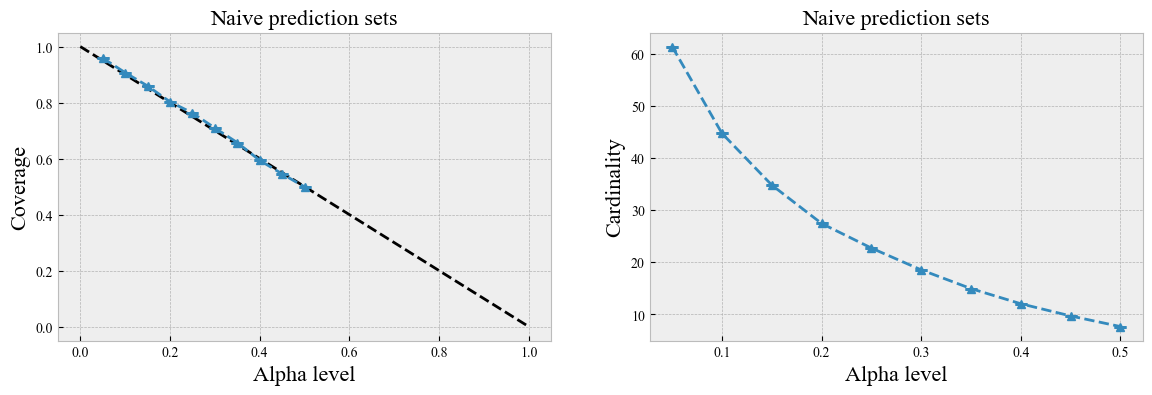

In [23]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].set_title('Naive prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('Naive prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Adaptive prediction set (APS)

* Calibration set for correct marginal coverage

In [24]:
importlib.reload(conformal)

<module 'src.conformal' from 'C:\\Grad\\Classes\\CS598\\Paper\\conformal-predictors-in-medical-imaging\\src\\conformal.py'>

In [25]:
# calibrate 
aps_qhat = collections.defaultdict(dict)

# scores & labels have the same length
# scores is a 2D array. The first dimension represents the images
# and the second dimension represents the score on each of the 114
# total classes. They add up to 1 (i.e. len(scores[0]))
scores = [x for x in valid_df.scores.values]
labels = [x for x in valid_df.label.values]
#labels = torch.arange(114).repeat(len(scores), 1)

#print(labels)

assert math.isclose(sum(scores[0]), 1, rel_tol=0.001, abs_tol=0.001)

for alpha in ALPHAS:
    qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
    aps_qhat[alpha] = qhat.item()
        
aps_qhat = dict(aps_qhat)

In [26]:
print(aps_qhat[0.1])

0.8711376190185547


In [27]:
# inference
scores = [x for x in test_df.scores.values]
for alpha in ALPHAS:
    qhat = aps_qhat[alpha]
    test_df[f'aps_{alpha}'] = conformal.conformal_inference(scores, qhat)

In [28]:
columns = [f'aps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,aps_0.05,aps_0.1,aps_0.15,aps_0.2,aps_0.25,aps_0.3,aps_0.35,aps_0.4,aps_0.45,aps_0.5
3179,"[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57]","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48]","[45, 7, 95, 73, 76, 70, 58, 92]"
1588,"[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 34]","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65]","[29, 47, 63, 50, 80, 99, 86, 15]"
8016,"[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73]","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41]","[104, 70, 57, 77, 58, 61, 95, 7, 76]"
2990,"[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1..."
299,"[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8..."


In [29]:
alpha, aps_coverage_mean, aps_coverage_std = aggregate_coverage(test_df, prefix='aps')
alpha, aps_cardinality_mean, aps_cardinality_std = aggregate_cardinality(test_df, prefix='aps')

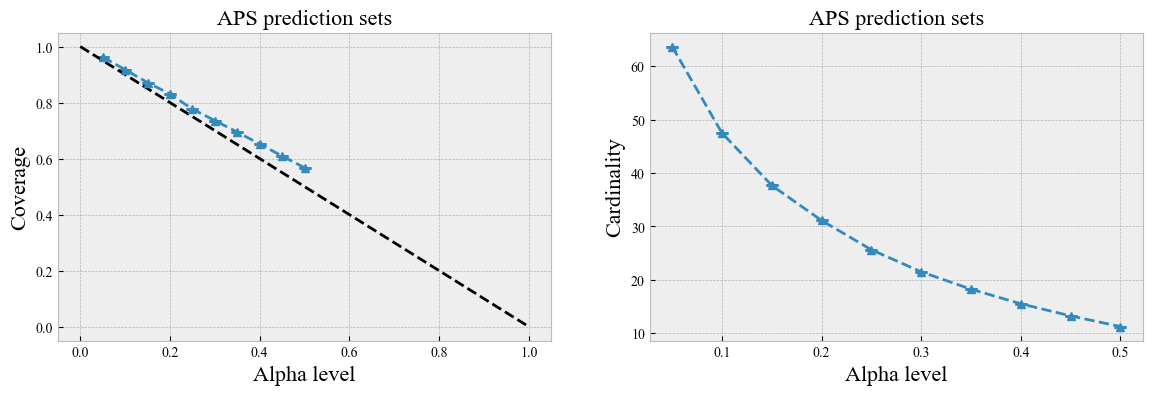

In [30]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('APS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('APS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group APS (GAPS)

Conformal calibration for each subgroup 

In [31]:
# calibrate 
gaps_qhat = collections.defaultdict(dict)

#for k, df in valid_dfs.items():

alpha_qhat = collections.defaultdict(dict)
for alpha in ALPHAS: # [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    group_qhat = collections.defaultdict(dict)
    for a in A: # [6, 5, 4, 3, 2, 1]
        group_df = valid_df[valid_df.fitzpatrick_scale == a]
        
        scores = [x for x in group_df.scores.values]
        
        labels = [x for x in group_df.label.values]
        qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
        gaps_qhat[alpha] = qhat.item()

        group_qhat[a] = qhat

    alpha_qhat[alpha] = dict(group_qhat)

gaps_qhat = dict(alpha_qhat)
#end for loop

In [32]:
# inference

#for k, df in test_dfs.items():
temp = []
scores = np.array([x for x in test_df.scores.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for a in A:
    group_df = test_df[test_df.fitzpatrick_scale == a].copy()

    # APS
    scores = [x for x in group_df.scores.values]
    for alpha in ALPHAS:
        qhat = gaps_qhat[alpha][a]
        group_df[f'gaps_{alpha}'] = conformal.conformal_inference(scores, qhat)

    temp.append(group_df)
test_df = pd.concat(temp)

In [33]:
# columns = [f'gaps_{alpha}' for alpha in ALPHAS]
columns = [f'gaps_{alpha}' for alpha in ALPHAS]
print(len(test_df[columns]))
test_df[columns].sort_index().head()

3306


,gaps_0.05,gaps_0.1,gaps_0.15,gaps_0.2,gaps_0.25,gaps_0.3,gaps_0.35,gaps_0.4,gaps_0.45,gaps_0.5
0,"[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10..."
1,"[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57..."
2,"[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19]","[12, 93, 29, 64, 40, 21, 20, 34, 63]"
3,"[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2..."
4,"[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9..."


In [34]:
alpha, gaps_coverage_mean, gaps_coverage_std = aggregate_coverage(test_df, prefix='gaps')
alpha, gaps_cardinality_mean, gaps_cardinality_std = aggregate_cardinality(test_df, prefix='gaps')

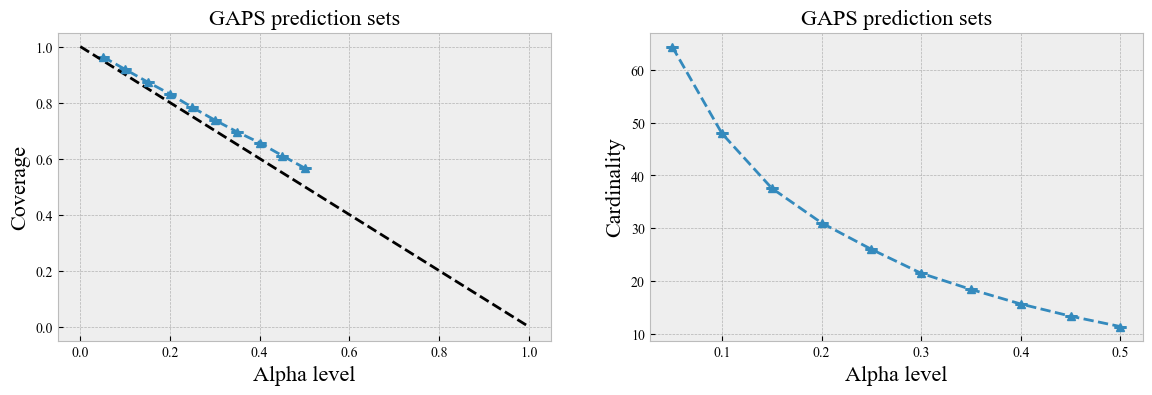

In [35]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, gaps_coverage_mean, yerr=gaps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('GAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, gaps_cardinality_mean, yerr=gaps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('GAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Regularized adaptive prediction set (RAPS)

* Calibration set for correct marginal coverage
* Parameterized regulaization penality $\lambda$ and $K$

In [36]:
K_REG = 0
LAMBDA = 1e-4

penalty = np.zeros((1, C))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

In [37]:
# calibrate 
raps_qhat = collections.defaultdict(dict)
#for k, df in valid_dfs.items():
scores = np.array([x for x in valid_df.scores.values])
labels = np.array([x for x in valid_df.label.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for alpha in ALPHAS:
    qhat = conformal.raps_calibrate(
        scores, labels, index, ordered, cumsum,
        penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
    )
    raps_qhat[alpha] = qhat
        
raps_qhat = dict(raps_qhat)

In [38]:
print(raps_qhat[0.05])

0.9427231312058195


In [39]:
# inference
#for k, df in test_dfs.items():
scores = np.array([x for x in test_df.scores.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for alpha in ALPHAS:
    qhat = raps_qhat[alpha]
    test_df[f'raps_{alpha}'] = conformal.raps_predict(
        C, qhat, index, ordered, cumsum, 
        penalty, randomized=RAND, allow_zero_sets=ZERO,
    )

In [40]:
columns = [f'raps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,raps_0.05,raps_0.1,raps_0.15,raps_0.2,raps_0.25,raps_0.3,raps_0.35,raps_0.4,raps_0.45,raps_0.5
2868,"[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62]","[71, 0]","[71, 0]",[71],[71],[71],[71],[71]
2509,"[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92..."
6809,"[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8]","[108, 54, 33, 11, 107, 98, 30, 100, 61]","[108, 54, 33, 11, 107, 98]","[108, 54, 33, 11, 107]","[108, 54, 33, 11]"
6360,"[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51]","[80, 15, 20, 60, 92, 113, 42, 86, 22]"
3312,"[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5..."


In [41]:
alpha, raps_coverage_mean, raps_coverage_std = aggregate_coverage(test_df, prefix='raps')
alpha, raps_cardinality_mean, raps_cardinality_std = aggregate_cardinality(test_df, prefix='raps')

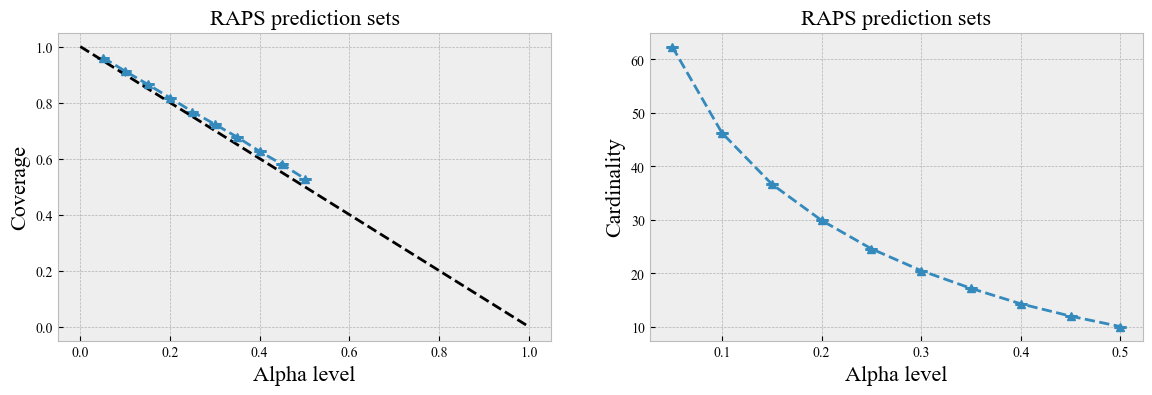

In [42]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('RAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('RAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group RAPS (GRAPS)

In [43]:
# calibrate 
graps_qhat = collections.defaultdict(dict)

#for k, df in valid_dfs.items():
alpha_qhat = collections.defaultdict(dict)
for alpha in ALPHAS:
    group_qhat = collections.defaultdict(dict)
    for a in A:
        group_df = valid_df[valid_df.fitzpatrick_scale == a]

        scores = np.array([x for x in group_df.scores.values])
        labels = np.array([x for x in group_df.label.values])
        index, ordered, cumsum = conformal.sort_sum(scores)
        qhat = conformal.raps_calibrate(
            scores, labels, index, ordered, cumsum,
            penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
        )

        group_qhat[a] = qhat

    alpha_qhat[alpha] = dict(group_qhat)

graps_qhat = dict(alpha_qhat)

In [44]:
# inference

#for k, df in test_dfs.items():
temp = []
for a in A:
    group_df = test_df[test_df.fitzpatrick_scale == a].copy()
    # RAPS
    scores = np.array([x for x in group_df.scores.values])
    for alpha in ALPHAS:
        qhat = graps_qhat[alpha][a]
        index, ordered, cumsum = conformal.sort_sum(scores)
        group_df[f'graps_{alpha}'] = conformal.raps_predict(
            C, qhat.item(), index, ordered, cumsum, 
            penalty, randomized=RAND, allow_zero_sets=ZERO,
        )

    temp.append(group_df)
    print(group_df.columns.values)
test_df = pd.concat(temp)

print(test_df.columns.values)

['hasher' 'label' 'fitzpatrick_scale' 'prediction_probability'
 'prediction' 'd1' 'd2' 'd3' 'p1' 'p2' 'p3' 'logit_class_0'
 'logit_class_1' 'logit_class_2' 'logit_class_3' 'logit_class_4'
 'logit_class_5' 'logit_class_6' 'logit_class_7' 'logit_class_8'
 'logit_class_9' 'logit_class_10' 'logit_class_11' 'logit_class_12'
 'logit_class_13' 'logit_class_14' 'logit_class_15' 'logit_class_16'
 'logit_class_17' 'logit_class_18' 'logit_class_19' 'logit_class_20'
 'logit_class_21' 'logit_class_22' 'logit_class_23' 'logit_class_24'
 'logit_class_25' 'logit_class_26' 'logit_class_27' 'logit_class_28'
 'logit_class_29' 'logit_class_30' 'logit_class_31' 'logit_class_32'
 'logit_class_33' 'logit_class_34' 'logit_class_35' 'logit_class_36'
 'logit_class_37' 'logit_class_38' 'logit_class_39' 'logit_class_40'
 'logit_class_41' 'logit_class_42' 'logit_class_43' 'logit_class_44'
 'logit_class_45' 'logit_class_46' 'logit_class_47' 'logit_class_48'
 'logit_class_49' 'logit_class_50' 'logit_class_51' 'logit

['hasher' 'label' 'fitzpatrick_scale' 'prediction_probability'
 'prediction' 'd1' 'd2' 'd3' 'p1' 'p2' 'p3' 'logit_class_0'
 'logit_class_1' 'logit_class_2' 'logit_class_3' 'logit_class_4'
 'logit_class_5' 'logit_class_6' 'logit_class_7' 'logit_class_8'
 'logit_class_9' 'logit_class_10' 'logit_class_11' 'logit_class_12'
 'logit_class_13' 'logit_class_14' 'logit_class_15' 'logit_class_16'
 'logit_class_17' 'logit_class_18' 'logit_class_19' 'logit_class_20'
 'logit_class_21' 'logit_class_22' 'logit_class_23' 'logit_class_24'
 'logit_class_25' 'logit_class_26' 'logit_class_27' 'logit_class_28'
 'logit_class_29' 'logit_class_30' 'logit_class_31' 'logit_class_32'
 'logit_class_33' 'logit_class_34' 'logit_class_35' 'logit_class_36'
 'logit_class_37' 'logit_class_38' 'logit_class_39' 'logit_class_40'
 'logit_class_41' 'logit_class_42' 'logit_class_43' 'logit_class_44'
 'logit_class_45' 'logit_class_46' 'logit_class_47' 'logit_class_48'
 'logit_class_49' 'logit_class_50' 'logit_class_51' 'logit

In [45]:
columns = [f'graps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,graps_0.05,graps_0.1,graps_0.15,graps_0.2,graps_0.25,graps_0.3,graps_0.35,graps_0.4,graps_0.45,graps_0.5
2868,"[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47]","[71, 0, 10, 58]","[71, 0]",[71],[71],[71],[71],[71]
2509,"[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92..."
6809,"[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8]","[108, 54, 33, 11, 107, 98, 30, 100, 61]","[108, 54, 33, 11, 107, 98, 30]","[108, 54, 33, 11, 107]"
6360,"[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19]"
3312,"[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5..."


In [46]:
alpha, graps_coverage_mean, graps_coverage_std = aggregate_coverage(test_df, prefix='graps')
alpha, graps_cardinality_mean, graps_cardinality_std = aggregate_cardinality(test_df, prefix='graps')

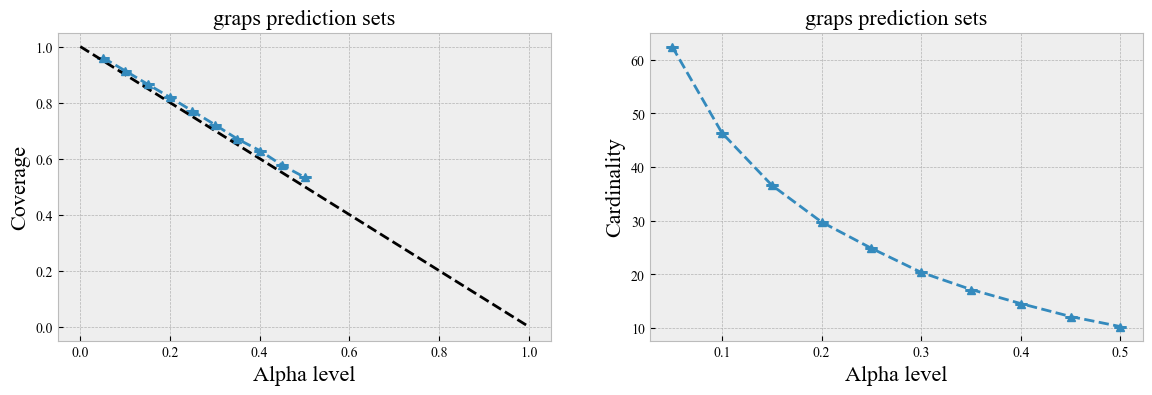

In [47]:

fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, graps_coverage_mean, yerr=graps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('graps prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, graps_cardinality_mean, yerr=graps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('graps prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Overall comparison

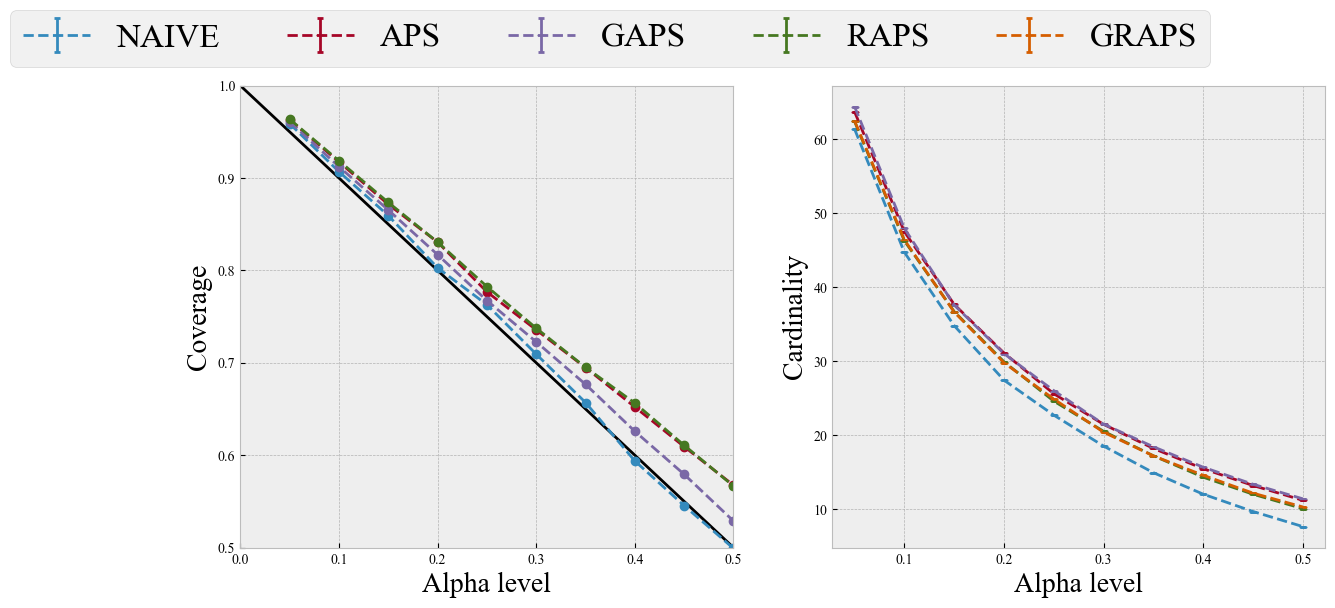

In [48]:
capsize = 2
fontsize=20
capthick=2
lw = 2
marker='o'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
ax[0].set_xlim(0, 0.5)
ax[0].set_ylim(0.5, 1)
ax[0].plot([1, 0], [0, 1], c='k', label='Ideal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[0].errorbar(
    alpha, gaps_coverage_mean , yerr=gaps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[1].errorbar(
    alpha, gaps_cardinality_mean , yerr=gaps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[1].errorbar(
    alpha, graps_cardinality_mean , yerr=graps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GRAPS',
)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.legend(fontsize=fontsize + 4, bbox_to_anchor=(0.8, 1.2), ncol=5)
plt.savefig(fig_dir / 'fitz-compare.png')
plt.show()

### Subgroup comparison

In [49]:
alpha, naive_subgroup_coverage_mean, naive_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='naive'
)
alpha, naive_subgroup_cardinality_mean, naive_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='naive'
)
alpha, aps_subgroup_coverage_mean, aps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='aps'
)
alpha, aps_subgroup_cardinality_mean, aps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='aps'
)
alpha, raps_subgroup_coverage_mean, raps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='raps'
)
alpha, raps_subgroup_cardinality_mean, raps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='raps'
)
alpha, gaps_subgroup_coverage_mean, gaps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='gaps'
)
alpha, gaps_subgroup_cardinality_mean, gaps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='gaps'
)
alpha, graps_subgroup_coverage_mean, graps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='graps'
)
alpha, graps_subgroup_cardinality_mean, graps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='graps'
)

2023-05-05 08:11:32,436 - maxp pruned
2023-05-05 08:11:32,439 - cmap pruned
2023-05-05 08:11:32,439 - post pruned
2023-05-05 08:11:32,443 - PCLT dropped
2023-05-05 08:11:32,447 - name pruned
2023-05-05 08:11:32,451 - 'created' timestamp seems very low; regarding as unix timestamp
2023-05-05 08:11:32,457 - 'modified' timestamp seems very low; regarding as unix timestamp
2023-05-05 08:11:32,461 - glyf pruned
2023-05-05 08:11:32,461 - Added gid0 to subset
2023-05-05 08:11:32,465 - Added first four glyphs to subset
2023-05-05 08:11:32,469 - Closing glyph list over 'glyf': 5 glyphs before
2023-05-05 08:11:32,473 - Glyph names: ['.notdef', '.null', 'alpha', 'e', 'nonmarkingreturn']
2023-05-05 08:11:32,478 - Glyph IDs:   [0, 1, 2, 3, 13]
2023-05-05 08:11:32,482 - Closed glyph list over 'glyf': 5 glyphs after
2023-05-05 08:11:32,482 - Glyph names: ['.notdef', '.null', 'alpha', 'e', 'nonmarkingreturn']
2023-05-05 08:11:32,486 - Glyph IDs:   [0, 1, 2, 3, 13]
2023-05-05 08:11:32,490 - Retaining 5

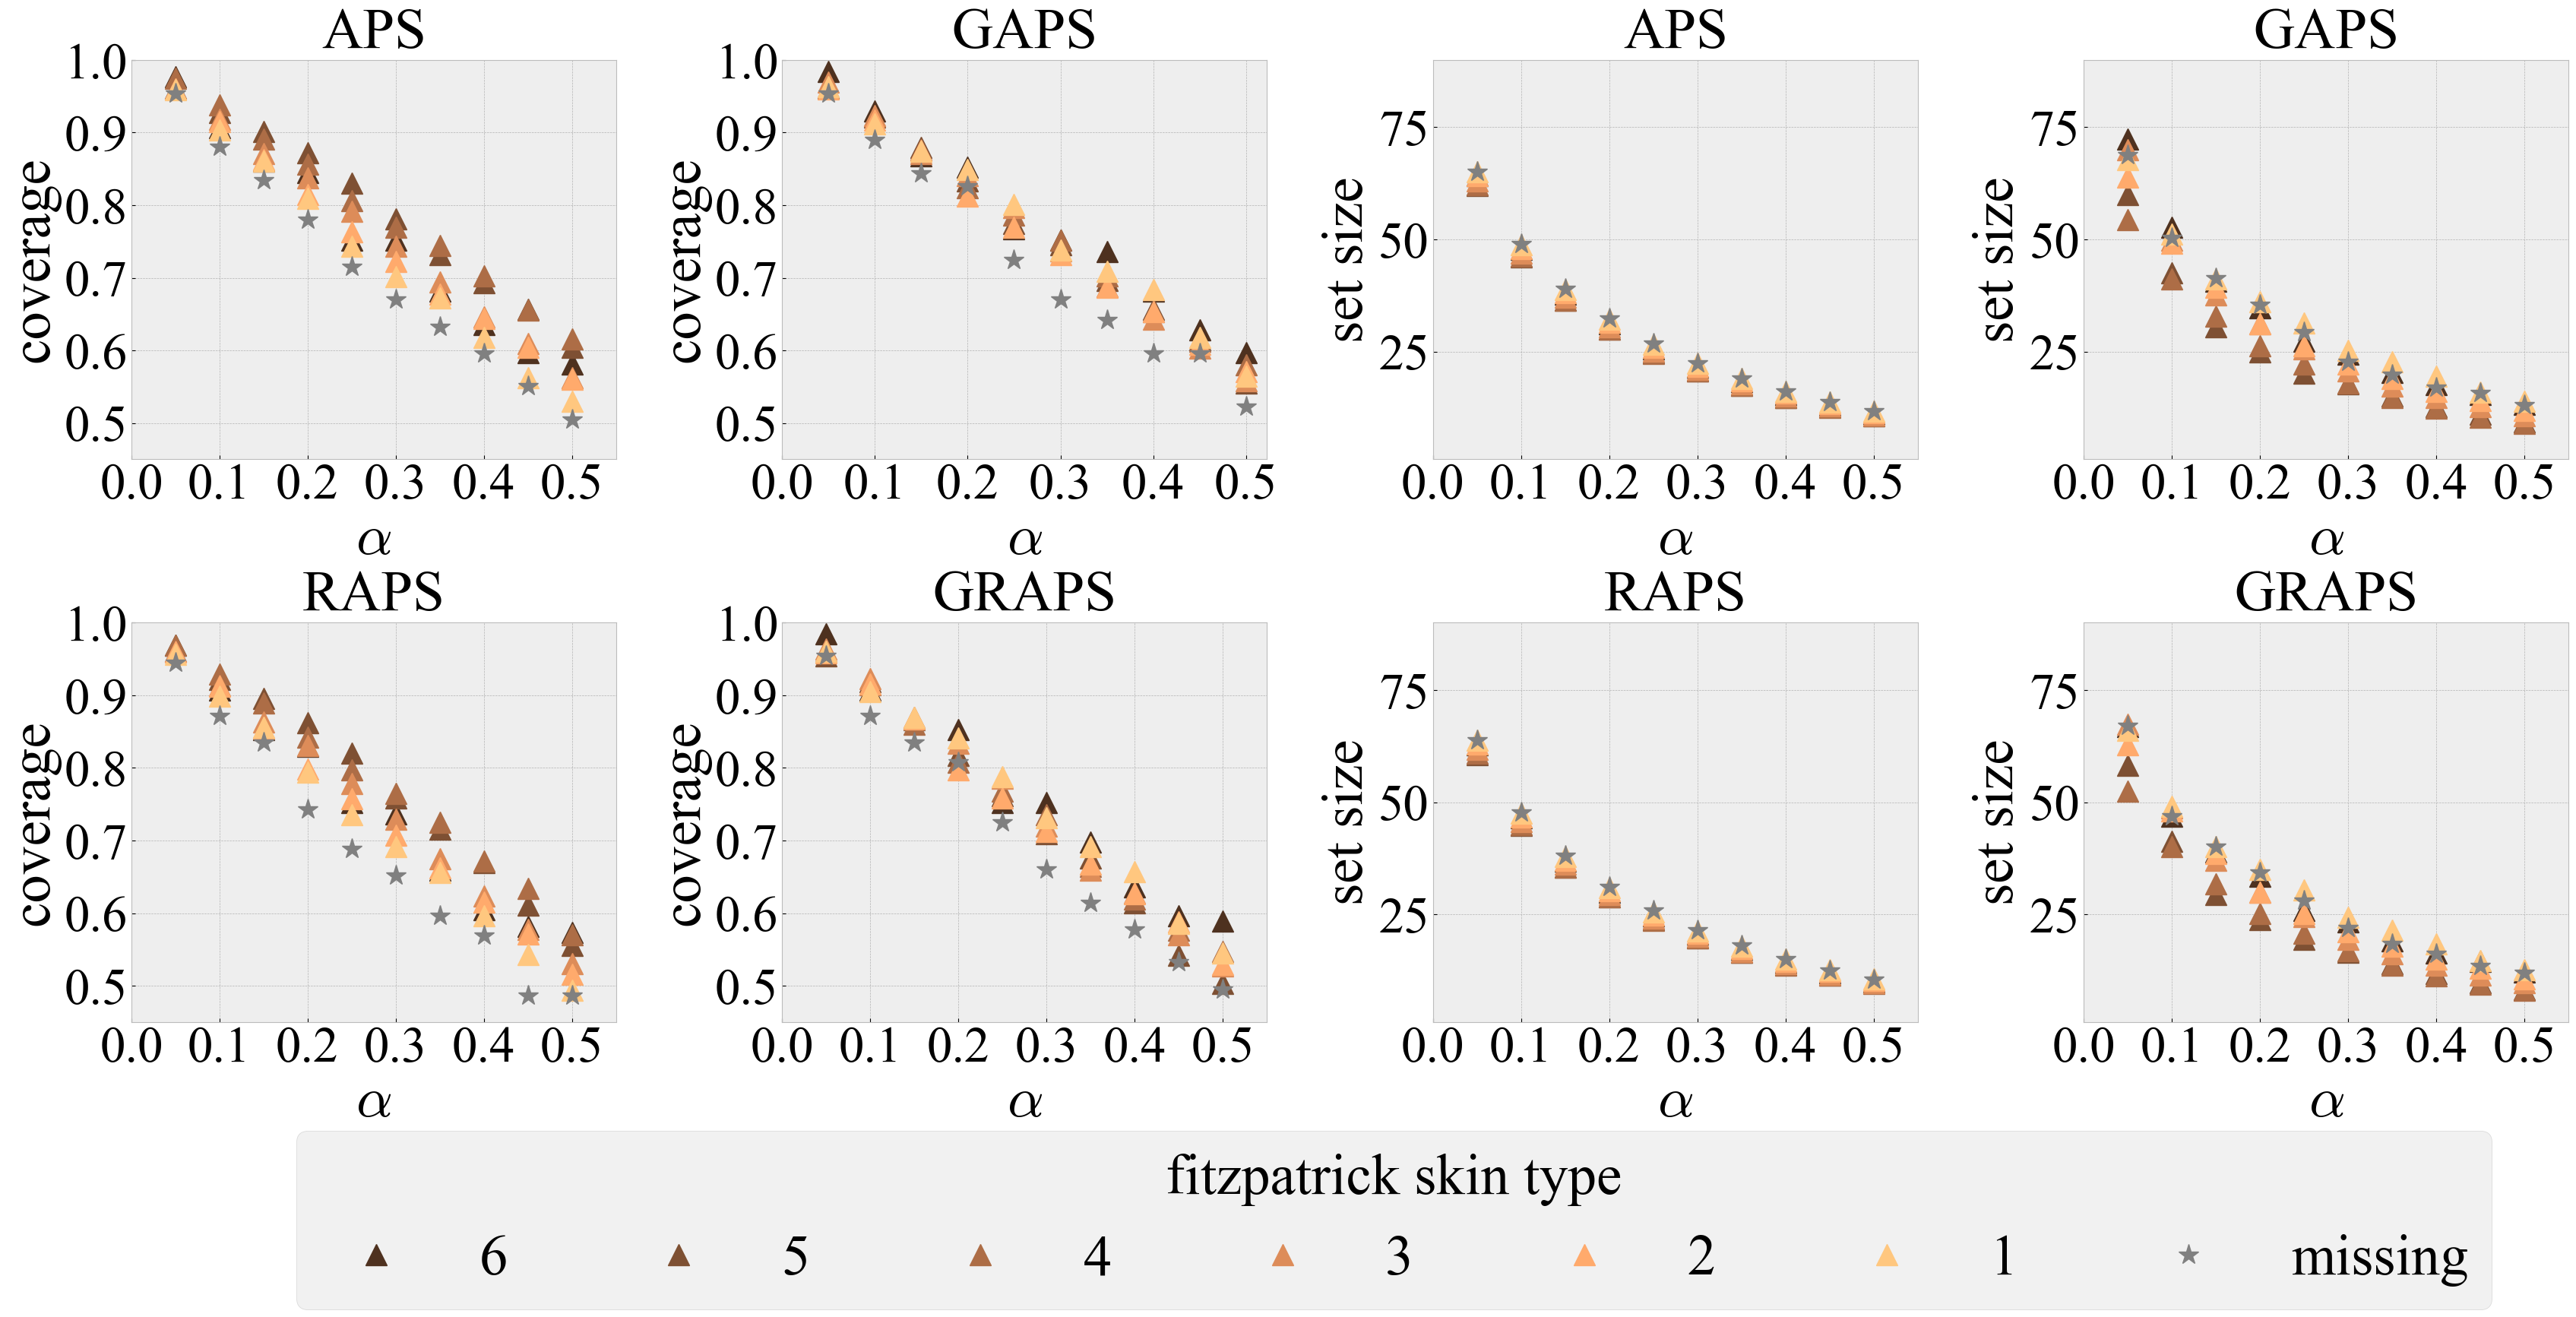

In [50]:
fontsize=54
labelsize=48
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(34, 18), sharex=False, sharey=False)
ls=''
lw=6
marker = '^'
ms = 20
alpha=1.0
xticks = np.arange(0.0, 0.51, 0.1)
yticks = np.arange(0.5, 1.01, 0.1)
xlim = (0, 0.55)
ylim = (0.45, 1.0)


# ax[0, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(aps_subgroup_coverage_mean.items()):
    ax[0, 0].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 0].set_title('APS', fontsize=fontsize )
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_ylim(*ylim)
ax[0, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 0].set_ylabel('coverage', fontsize=fontsize)
ax[0, 0].set_xticks(xticks)
ax[0, 0].set_yticks(yticks)
ax[0, 0].tick_params(axis='x', labelsize=labelsize)
ax[0, 0].tick_params(axis='y', labelsize=labelsize)

# ax[1, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(raps_subgroup_coverage_mean.items()):
    ax[1, 0].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 0].set_title('RAPS', fontsize=fontsize)
ax[1, 0].set_xlim(*xlim)
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 0].set_ylabel('coverage', fontsize=fontsize)
ax[1, 0].set_xticks(xticks)
ax[1, 0].set_yticks(yticks)
ax[1, 0].tick_params(axis='x', labelsize=labelsize)
ax[1, 0].tick_params(axis='y', labelsize=labelsize)

# ax[0, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(gaps_subgroup_coverage_mean.items()):
    ax[0, 1].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 1].set_title('GAPS', fontsize=fontsize)
ax[0, 1].set_ylim(*ylim)
ax[0, 1].set_ylim(*ylim)
ax[0, 1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 1].set_ylabel('coverage', fontsize=fontsize)
ax[0, 1].set_xticks(xticks)
ax[0, 1].set_yticks(yticks)
ax[0, 1].tick_params(axis='x', labelsize=labelsize )
ax[0, 1].tick_params(axis='y', labelsize=labelsize)

# ax[1, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(graps_subgroup_coverage_mean.items()):
    ax[1, 1].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 1].set_title('GRAPS', fontsize=fontsize)
ax[1, 1].set_xlim(*xlim)
ax[1, 1].set_ylim(*ylim)
ax[1, 1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 1].set_ylabel('coverage', fontsize=fontsize)
ax[1, 1].set_xticks(xticks)
ax[1, 1].set_yticks(yticks)
ax[1, 1].tick_params(axis='x', labelsize=labelsize )
ax[1, 1].tick_params(axis='y', labelsize=labelsize)

xticks = np.arange(0.0, 0.6, 0.1)
yticks = np.arange(0, 1.1, 0.1)
xlim = (0, 0.55)
ylim = (1, 90)

for i, (k, v) in enumerate(aps_subgroup_cardinality_mean.items()):
    ax[0, 2].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[0, 2].set_xlim(*xlim)
ax[0, 2].set_ylim(*ylim)
ax[0, 2].set_title('APS', fontsize=fontsize )
ax[0, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 2].set_ylabel('set size', fontsize=fontsize)
ax[0, 2].set_xticks(xticks)
ax[0, 2].tick_params(axis='x', labelsize=labelsize)
ax[0, 2].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(raps_subgroup_cardinality_mean.items()):
    ax[1, 2].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 2].set_xlim(*xlim)
ax[1, 2].set_ylim(*ylim)
ax[1, 2].set_title('RAPS', fontsize=fontsize )
ax[1, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 2].set_ylabel('set size', fontsize=fontsize)
ax[1, 2].set_xticks(xticks)
ax[1, 2].tick_params(axis='x', labelsize=labelsize)
ax[1, 2].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(gaps_subgroup_cardinality_mean.items()):
    ax[0, 3].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[0, 3].set_xlim(*xlim)
ax[0, 3].set_ylim(*ylim)
ax[0, 3].set_title('GAPS', fontsize=fontsize )
ax[0, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 3].set_ylabel('set size', fontsize=fontsize)
ax[0, 3].set_xticks(xticks)
ax[0, 3].tick_params(axis='x', labelsize=labelsize)
ax[0, 3].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(graps_subgroup_cardinality_mean.items()):
    ax[1, 3].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 3].set_xlim(*xlim)
ax[1, 3].set_ylim(*ylim)
ax[1, 3].set_title('GRAPS', fontsize=fontsize )
ax[1, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 3].set_ylabel('set size', fontsize=fontsize)
ax[1, 3].set_xticks(xticks)
ax[1, 3].tick_params(axis='x', labelsize=labelsize)
ax[1, 3].tick_params(axis='y', labelsize=labelsize)

handles, labels = ax[0, 0].get_legend_handles_labels()


plt.tight_layout(h_pad=4, w_pad=4)
plt.subplots_adjust(bottom=0.25)
plt.legend(
    handles,
    labels,
    title='fitzpatrick skin type', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize,
    },
    fontsize=fontsize,
    bbox_to_anchor=(0.90, -0.20, 0.0, 0),
    ncol=7,
)

plt.savefig(fig_dir / 'fitz-subgroup-coverage.pdf', bbox_inches="tight")
plt.show()

### Measure subgroup coverage / cardinaltiy disparity

In [51]:
def get_diff(res):
    diff = []
    for a, b in itertools.combinations(list(range(len(res))), 2):
        if a == b: continue
        diff.append(abs(res[a] - res[b]))
    return diff

In [52]:
coverage_disparity = {}
print('COVERAGE'.center(20, '='))
for a in ALPHAS:
    naive_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'naive_{a}').items():
        naive_sub_cov[sub].append(cov)
    naive_sub_cov = dict(naive_sub_cov)

    aps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'aps_{a}').items():
        aps_sub_cov[sub].append(cov)
    aps_sub_cov = dict(aps_sub_cov)

    raps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'raps_{a}').items():
        raps_sub_cov[sub].append(cov)
    raps_sub_cov = dict(raps_sub_cov)

    gaps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'gaps_{a}').items():
        gaps_sub_cov[sub].append(cov)
    gaps_sub_cov = dict(gaps_sub_cov)
    
    graps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'graps_{a}').items():
        graps_sub_cov[sub].append(cov)
    graps_sub_cov = dict(graps_sub_cov)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_cov))
    print('aps\t', f(aps_sub_cov))
    print('raps\t', f(raps_sub_cov))
    print('gaps\t', f(gaps_sub_cov))
    print('graps\t', f(graps_sub_cov))

    coverage_disparity[a] = {
        'naive': f(naive_sub_cov),
        'aps': f(aps_sub_cov),
        'raps': f(raps_sub_cov),
        'gaps': f(gaps_sub_cov),
        'graps': f(graps_sub_cov),
    }

======COVERAGE======

alpha: 0.05
naive	 (0.015, 0.011)
aps	 (0.01, 0.007)
raps	 (0.009, 0.007)
gaps	 (0.011, 0.009)
graps	 (0.011, 0.01)

alpha: 0.1
naive	 (0.026, 0.016)
aps	 (0.022, 0.014)
raps	 (0.021, 0.016)
gaps	 (0.014, 0.012)
graps	 (0.018, 0.016)

alpha: 0.15
naive	 (0.037, 0.023)
aps	 (0.026, 0.017)
raps	 (0.025, 0.017)
gaps	 (0.012, 0.012)
graps	 (0.012, 0.013)

alpha: 0.2
naive	 (0.054, 0.032)
aps	 (0.038, 0.023)
raps	 (0.046, 0.031)
gaps	 (0.018, 0.01)
graps	 (0.025, 0.015)

alpha: 0.25
naive	 (0.052, 0.032)
aps	 (0.048, 0.028)
raps	 (0.052, 0.032)
gaps	 (0.029, 0.021)
graps	 (0.025, 0.017)

alpha: 0.3
naive	 (0.048, 0.031)
aps	 (0.048, 0.028)
raps	 (0.048, 0.03)
gaps	 (0.028, 0.029)
graps	 (0.033, 0.025)

alpha: 0.35
naive	 (0.068, 0.041)
aps	 (0.045, 0.029)
raps	 (0.05, 0.034)
gaps	 (0.032, 0.024)
graps	 (0.031, 0.023)

alpha: 0.4
naive	 (0.07, 0.043)
aps	 (0.046, 0.029)
raps	 (0.045, 0.029)
gaps	 (0.033, 0.025)
graps	 (0.027, 0.02)

alpha: 0.45
naive	 (0.07, 0.042)
aps	

In [53]:
cardinality_disparity = {}
print('CARDINALITY'.center(20, '='))
for a in ALPHAS:
    naive_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'naive_{a}').items():
        naive_sub_card[sub].append(card)
    naive_sub_card = dict(naive_sub_card)

    aps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'aps_{a}').items():
        aps_sub_card[sub].append(card)
    aps_sub_card = dict(aps_sub_card)

    raps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'raps_{a}').items():
        raps_sub_card[sub].append(card)
    raps_sub_card = dict(raps_sub_card)

    gaps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'gaps_{a}').items():
        gaps_sub_card[sub].append(card)
    gaps_sub_card = dict(gaps_sub_card)
    
    graps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'graps_{a}').items():
        graps_sub_card[sub].append(card)
    graps_sub_card = dict(graps_sub_card)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 1)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 1)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_card))
    print('aps\t', f(aps_sub_card))
    print('raps\t', f(raps_sub_card))
    print('gaps\t', f(gaps_sub_card))
    print('graps\t', f(graps_sub_card))
   
    cardinality_disparity[a] = {
        'naive': f(naive_sub_card),
        'aps': f(aps_sub_card),
        'raps': f(raps_sub_card),
        'gaps': f(gaps_sub_card),
        'graps': f(graps_sub_card),
    }

====CARDINALITY=====

alpha: 0.05
naive	 (1.4, 0.8)
aps	 (1.5, 1.0)
raps	 (1.5, 0.9)
gaps	 (7.5, 4.8)
graps	 (6.3, 4.9)

alpha: 0.1
naive	 (1.1, 0.7)
aps	 (1.4, 0.8)
raps	 (1.4, 0.8)
gaps	 (5.0, 3.7)
graps	 (4.1, 3.1)

alpha: 0.15
naive	 (0.8, 0.4)
aps	 (1.3, 0.8)
raps	 (1.3, 0.8)
gaps	 (4.9, 3.5)
graps	 (4.8, 3.6)

alpha: 0.2
naive	 (0.4, 0.3)
aps	 (1.2, 0.7)
raps	 (1.1, 0.7)
gaps	 (5.3, 3.4)
graps	 (5.3, 3.3)

alpha: 0.25
naive	 (0.3, 0.2)
aps	 (1.0, 0.6)
raps	 (1.0, 0.6)
gaps	 (4.8, 2.8)
graps	 (4.6, 2.8)

alpha: 0.3
naive	 (0.3, 0.2)
aps	 (0.9, 0.5)
raps	 (0.8, 0.5)
gaps	 (3.6, 2.1)
graps	 (3.7, 2.2)

alpha: 0.35
naive	 (0.2, 0.2)
aps	 (0.8, 0.5)
raps	 (0.8, 0.5)
gaps	 (3.5, 2.1)
graps	 (3.4, 2.0)

alpha: 0.4
naive	 (0.2, 0.1)
aps	 (0.7, 0.4)
raps	 (0.7, 0.4)
gaps	 (3.2, 1.9)
graps	 (3.1, 1.8)

alpha: 0.45
naive	 (0.2, 0.1)
aps	 (0.6, 0.4)
raps	 (0.6, 0.3)
gaps	 (2.8, 1.7)
graps	 (2.6, 1.6)

alpha: 0.5
naive	 (0.2, 0.1)
aps	 (0.5, 0.3)
raps	 (0.5, 0.3)
gaps	 (2.3, 1.4)
graps	 (2.3,

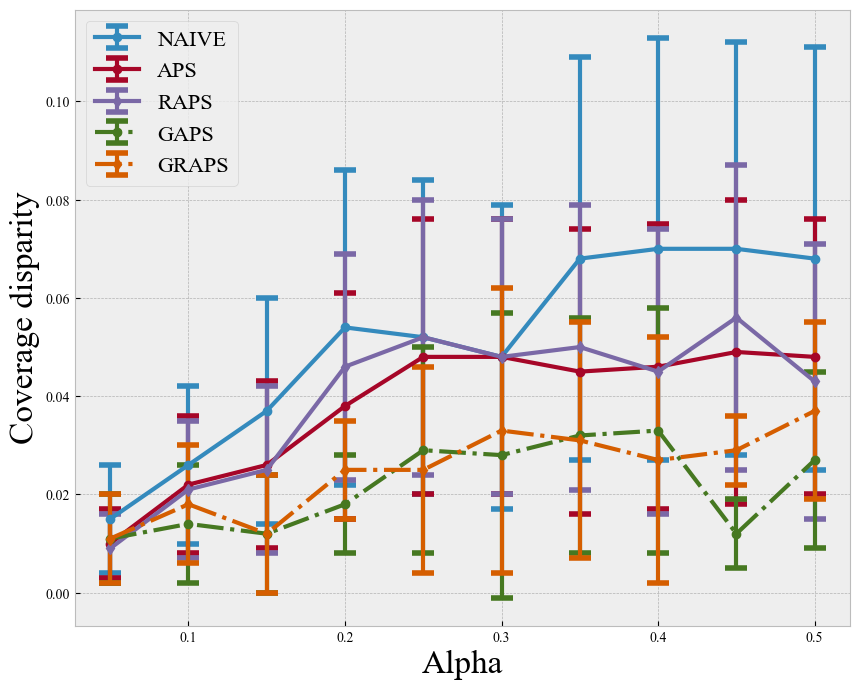

In [54]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Coverage disparity', fontsize=24)

plt.errorbar(
    coverage_disparity.keys(),
    [x['naive'][0] for x in coverage_disparity.values()],
    yerr=[x['naive'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['aps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['raps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['gaps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['graps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-coverage-disparity.png')
plt.show()

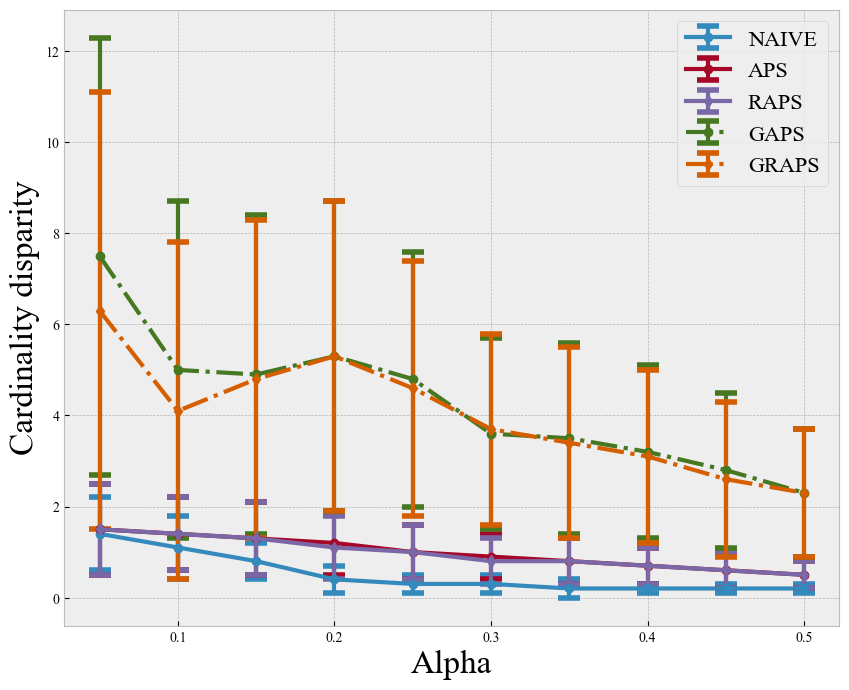

In [55]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Cardinality disparity', fontsize=24)

plt.errorbar(
    cardinality_disparity.keys(),
    [x['naive'][0] for x in cardinality_disparity.values()],
    yerr=[x['naive'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['aps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['raps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['gaps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['graps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-cardinality-disparity.png')
plt.show()

## Distribution of prediction set sizes by subgroup

In [ ]:
fontsize = 24
width = 0.12
alpha = 0.1
# alpha = 0.2

def set_box_color(bp, color):
    plt.setp(bp['boxes'], facecolor=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color='k')
    
def set_violin_color(violin, color):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
        
    violin['cbars'].set_edgecolor(color)
    violin['cmaxes'].set_edgecolor(color)
    violin['cmins'].set_edgecolor(color)
    violin['cmedians'].set_edgecolor(color)
    violin['cmedians'].set_linewidth(6)
        
plt.figure(figsize=(12, 4))
plt.xticks(A[1:], fontsize=fontsize - 4)
plt.xlabel('Fitzpatrick group', fontsize=fontsize + 4)
plt.ylabel('Set size', fontsize=fontsize + 4)
plt.yticks(range(0, 120, 10), fontsize=fontsize - 8)
plt.xlim(0.5, 6.5)
plt.ylim(0, 114)

for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            test_df[test_df.fitzpatrick_scale == i].apply(lambda x: len(x[f'naive_{alpha}']), axis=1)
        ]).mean(0),
        positions=[i - 0.30],
        widths=width,
        showmedians=True,
    )
    set_violin_color(violin, 'C0')


for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            test_df[test_df.fitzpatrick_scale == i].apply(lambda x: len(x[f'aps_{alpha}']), axis=1)
        ]).mean(0),
        positions=[i - 0.15],
        widths=width,
        showmedians=True,
    )
    set_violin_color(violin, 'C1')

for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            test_df[test_df.fitzpatrick_scale == i].apply(lambda x: len(x[f'raps_{alpha}']), axis=1)
        ]).mean(0),
        showmedians=True,
        positions=[i + 0.00],
        widths=width,
    )
    set_violin_color(violin, 'C2')
        
for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            test_df[test_df.fitzpatrick_scale == i].apply(lambda x: len(x[f'gaps_{alpha}']), axis=1)
        ]).mean(0),
        positions=[i+0.15],
        widths=width,
        showmedians=True,
        
    )
    set_violin_color(violin, 'C3')
    
    
for i in range(1, len(A)):
    violin = plt.violinplot(
        np.array([
            test_df[test_df.fitzpatrick_scale == i].apply(lambda x: len(x[f'graps_{alpha}']), axis=1)
        ]).mean(0),
        positions=[i+0.30],
        widths=width,
        showmedians=True,
    )
    set_violin_color(violin, 'C4')


a, = plt.plot([0,0], [0, 0],'C0', lw=12, alpha=0.7)
b, = plt.plot([0,0], [0, 0],'C1', lw=12, alpha=0.7)
c, = plt.plot([0,0], [0,0],'C2', lw=12, alpha=0.7)
d, = plt.plot([0,0], [0, 0],'C3', lw=12, alpha=0.7)
e, = plt.plot([0,0], [0, 0],'C4', lw=12, alpha=0.7)

plt.legend(
    (a, b, c, d, e),
    ['NAIVE', 'APS', 'RAPS', 'GAPS', 'GRAPS'],
    fontsize=fontsize - 4, 
    ncol=5,
    mode='expand',
    loc='upper center'
)
plt.tight_layout()
plt.savefig(fig_dir / 'fitz-boxplot-set-sizes.png')
plt.show()

## Ruling in and ruling out critical conditions

In [ ]:
malignant_conditions = {
    reversed_label_map[x]: x for x in 
    skin_df.query('three_partition_label == "malignant"').raw_label.unique().tolist()
}
malignant_conditions

In [ ]:
def rule_in(df, pred='aps_0.05', malignant_conditions=malignant_conditions.keys()):
    correct = 0
    total = 0

    for i, row in df.iterrows():
        if row['label'] in malignant_conditions:
            total += 1
            if row['label'] in row[pred]:
                correct += 1
    
    return correct / total

def rule_out(df, pred='aps_0.05'):
    correct = 0
    total = 0
    for i, row in df.iterrows():
        if row['label'] not in malignant_conditions:
            total += 1
            if len(set(row[pred]) & set(malignant_conditions)) == 0:
                correct += 1
                
    return correct / total

In [ ]:
naive_rule_in = collections.defaultdict(list)
aps_rule_in = collections.defaultdict(list)
gaps_rule_in = collections.defaultdict(list)
raps_rule_in = collections.defaultdict(list)
graps_rule_in = collections.defaultdict(list)

naive_rule_out = collections.defaultdict(list)
aps_rule_out = collections.defaultdict(list)
gaps_rule_out = collections.defaultdict(list)
raps_rule_out = collections.defaultdict(list)
graps_rule_out = collections.defaultdict(list)

naive_crit_set_size = collections.defaultdict(list)
aps_crit_set_size = collections.defaultdict(list)
gaps_crit_set_size = collections.defaultdict(list)
raps_crit_set_size = collections.defaultdict(list)
graps_crit_set_size = collections.defaultdict(list)

naive_non_crit_set_size = collections.defaultdict(list)
aps_non_crit_set_size = collections.defaultdict(list)
gaps_non_crit_set_size = collections.defaultdict(list)
raps_non_crit_set_size = collections.defaultdict(list)
graps_non_crit_set_size = collections.defaultdict(list)

for alpha in ALPHAS:
    df = test_df
    crit_df = df[df.label.isin(malignant_conditions)]
    non_crit_df = df[~df.label.isin(malignant_conditions)]

    naive_rule_in[alpha].append(rule_in(crit_df, f'naive_{alpha}'))
    aps_rule_in[alpha].append(rule_in(crit_df, f'aps_{alpha}'))
    gaps_rule_in[alpha].append(rule_in(crit_df, f'gaps_{alpha}'))
    raps_rule_in[alpha].append(rule_in(crit_df, f'raps_{alpha}'))
    graps_rule_in[alpha].append(rule_in(crit_df, f'graps_{alpha}'))

    naive_crit_set_size[alpha].append(crit_df[f'naive_{alpha}'].apply(len).mean())
    aps_crit_set_size[alpha].append(crit_df[f'aps_{alpha}'].apply(len).mean())
    gaps_crit_set_size[alpha].append(crit_df[f'gaps_{alpha}'].apply(len).mean())
    raps_crit_set_size[alpha].append(crit_df[f'raps_{alpha}'].apply(len).mean())
    graps_crit_set_size[alpha].append(crit_df[f'graps_{alpha}'].apply(len).mean())

    naive_rule_out[alpha].append(rule_out(non_crit_df, f'naive_{alpha}'))
    aps_rule_out[alpha].append(rule_out(non_crit_df, f'aps_{alpha}'))
    gaps_rule_out[alpha].append(rule_out(non_crit_df, f'gaps_{alpha}'))
    raps_rule_out[alpha].append(rule_out(non_crit_df, f'raps_{alpha}'))
    graps_rule_out[alpha].append(rule_out(non_crit_df, f'graps_{alpha}'))

    naive_non_crit_set_size[alpha].append(non_crit_df[f'naive_{alpha}'].apply(len).mean())
    aps_non_crit_set_size[alpha].append(non_crit_df[f'aps_{alpha}'].apply(len).mean())
    gaps_non_crit_set_size[alpha].append(non_crit_df[f'gaps_{alpha}'].apply(len).mean())
    raps_non_crit_set_size[alpha].append(non_crit_df[f'raps_{alpha}'].apply(len).mean())
    graps_non_crit_set_size[alpha].append(non_crit_df[f'graps_{alpha}'].apply(len).mean())

In [ ]:
markersize=8
fontsize=26
alpha=0.8
fmt1='o'
fmt2='X'
fmt3='D'

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14, 12)

ax[0, 0].set_title('Rule-in of critical condition', fontsize=fontsize + 4)
# ax[0, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 0].set_ylabel('Rule-in accuracy', fontsize=fontsize)
ax[0, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_ylim(0, 1.1)

ax[0, 1].set_title('Rule-out of critical condition', fontsize=fontsize + 4)
# ax[0, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 1].set_ylabel('Rule-out accuracy', fontsize=fontsize)
ax[0, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_ylim(0, 1.1)

# ax[1, 0].set_title('Rule-in', fontsize=fontsize + 4)
ax[1, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 0].set_ylabel('Rule-in set size', fontsize=fontsize)
ax[1, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 0].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 0].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 0].set_ylim(0, 80)

# ax[1, 1].set_title('Rule-out', fontsize=fontsize + 4)
ax[1, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 1].set_ylabel('Rule-out set size', fontsize=fontsize)
ax[1, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 1].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 1].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 1].set_ylim(0, 80)

# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.1, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[0, 1].text(0.1, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 0].text(0.1, 65, '95% confidence level', rotation=0, fontsize=fontsize)
# ax[1, 1].text(0.1, 65, '95% confidence level', rotation=0, fontsize=fontsize)

naive = np.array(list(naive_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[0, 0].legend(fontsize=fontsize-2, loc='lower left')

naive = np.array(list(naive_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[0, 1].legend(fontsize=fontsize-2, loc='upper left')

naive = np.array(list(naive_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[1, 0].legend(fontsize=fontsize-2, loc='upper right')

naive = np.array(list(naive_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)
raps = np.array(list(raps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, raps.mean(1), raps.std(1),
    fmt=fmt3, color='C2', markersize=markersize,
    label='RAPS', alpha=alpha - 0.2,
)
gaps = np.array(list(gaps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, gaps.mean(1), gaps.std(1),
    fmt=fmt2, color='C3', markersize=markersize,
    label='GAPS', alpha=alpha + 0.2,
)
graps = np.array(list(graps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, graps.mean(1), graps.std(1),
    fmt=fmt2, color='C4', markersize=markersize,
    label='GRAPS', alpha=alpha + 0.2,
)
ax[1, 1].legend(fontsize=fontsize -2, loc='upper right')

plt.tight_layout()
plt.savefig(fig_dir / 'fitz-use-case-perf')
plt.show()

## Comparing rule-in/out between subgroups at $\alpha = 0.1$

In [ ]:
all_group_naive_rule_in = {}
all_group_aps_rule_in = {}
all_group_gaps_rule_in = {}
all_group_raps_rule_in = {}
all_group_graps_rule_in = {}

all_group_naive_rule_out = {}
all_group_aps_rule_out = {}
all_group_gaps_rule_out = {}
all_group_raps_rule_out = {}
all_group_graps_rule_out = {}

all_group_naive_crit_set_size = {}
all_group_aps_crit_set_size = {}
all_group_gaps_crit_set_size = {}
all_group_raps_crit_set_size = {}
all_group_graps_crit_set_size = {}

all_group_naive_non_crit_set_size = {}
all_group_aps_non_crit_set_size = {}
all_group_gaps_non_crit_set_size = {}
all_group_raps_non_crit_set_size = {}
all_group_graps_non_crit_set_size = {}

for a in A:
    group_naive_rule_in = collections.defaultdict(list)
    group_aps_rule_in = collections.defaultdict(list)
    group_gaps_rule_in = collections.defaultdict(list)
    group_raps_rule_in = collections.defaultdict(list)
    group_graps_rule_in = collections.defaultdict(list)

    group_naive_rule_out = collections.defaultdict(list)
    group_aps_rule_out = collections.defaultdict(list)
    group_gaps_rule_out = collections.defaultdict(list)
    group_raps_rule_out = collections.defaultdict(list)
    group_graps_rule_out = collections.defaultdict(list)

    group_naive_crit_set_size = collections.defaultdict(list)
    group_aps_crit_set_size = collections.defaultdict(list)
    group_gaps_crit_set_size = collections.defaultdict(list)
    group_raps_crit_set_size = collections.defaultdict(list)
    group_graps_crit_set_size = collections.defaultdict(list)

    group_naive_non_crit_set_size = collections.defaultdict(list)
    group_aps_non_crit_set_size = collections.defaultdict(list)
    group_gaps_non_crit_set_size = collections.defaultdict(list)
    group_raps_non_crit_set_size = collections.defaultdict(list)
    group_graps_non_crit_set_size = collections.defaultdict(list)

    for alpha in ALPHAS:
        df = test_df
        sub_df = df.query('fitzpatrick_scale == @a')
        crit_df = sub_df[sub_df.label.isin(malignant_conditions)]
        non_crit_df = sub_df[~sub_df.label.isin(malignant_conditions)]

        group_naive_rule_in[alpha].append(rule_in(crit_df, f'naive_{alpha}'))
        group_aps_rule_in[alpha].append(rule_in(crit_df, f'aps_{alpha}'))
        group_gaps_rule_in[alpha].append(rule_in(crit_df, f'gaps_{alpha}'))
        group_raps_rule_in[alpha].append(rule_in(crit_df, f'raps_{alpha}'))
        group_graps_rule_in[alpha].append(rule_in(crit_df, f'graps_{alpha}'))

        group_naive_crit_set_size[alpha].append(crit_df[f'naive_{alpha}'].apply(len).mean())
        group_aps_crit_set_size[alpha].append(crit_df[f'aps_{alpha}'].apply(len).mean())
        group_gaps_crit_set_size[alpha].append(crit_df[f'gaps_{alpha}'].apply(len).mean())
        group_raps_crit_set_size[alpha].append(crit_df[f'raps_{alpha}'].apply(len).mean())
        group_graps_crit_set_size[alpha].append(crit_df[f'graps_{alpha}'].apply(len).mean())

        group_naive_rule_out[alpha].append(rule_out(non_crit_df, f'naive_{alpha}'))
        group_aps_rule_out[alpha].append(rule_out(non_crit_df, f'aps_{alpha}'))
        group_gaps_rule_out[alpha].append(rule_out(non_crit_df, f'gaps_{alpha}'))
        group_raps_rule_out[alpha].append(rule_out(non_crit_df, f'raps_{alpha}'))
        group_graps_rule_out[alpha].append(rule_out(non_crit_df, f'graps_{alpha}'))

        group_naive_non_crit_set_size[alpha].append(non_crit_df[f'naive_{alpha}'].apply(len).mean())
        group_aps_non_crit_set_size[alpha].append(non_crit_df[f'aps_{alpha}'].apply(len).mean())
        group_gaps_non_crit_set_size[alpha].append(non_crit_df[f'gaps_{alpha}'].apply(len).mean())
        group_raps_non_crit_set_size[alpha].append(non_crit_df[f'raps_{alpha}'].apply(len).mean())
        group_graps_non_crit_set_size[alpha].append(non_crit_df[f'graps_{alpha}'].apply(len).mean())
            
    all_group_naive_rule_in[a] = group_naive_rule_in
    all_group_aps_rule_in[a] = group_aps_rule_in
    all_group_gaps_rule_in[a] = group_gaps_rule_in
    all_group_raps_rule_in[a] = group_raps_rule_in
    all_group_graps_rule_in[a] = group_graps_rule_in
    
    all_group_naive_rule_out[a] = group_naive_rule_out
    all_group_aps_rule_out[a] = group_aps_rule_out
    all_group_gaps_rule_out[a] = group_gaps_rule_out
    all_group_raps_rule_out[a] = group_raps_rule_out
    all_group_graps_rule_out[a] = group_graps_rule_out
    
    all_group_naive_crit_set_size[a] = group_naive_crit_set_size
    all_group_aps_crit_set_size[a] = group_aps_crit_set_size
    all_group_gaps_crit_set_size[a] = group_gaps_crit_set_size
    all_group_raps_crit_set_size[a] = group_raps_crit_set_size
    all_group_graps_crit_set_size[a] = group_graps_crit_set_size
    
    all_group_naive_non_crit_set_size[a] = group_naive_non_crit_set_size
    all_group_aps_non_crit_set_size[a] = group_aps_non_crit_set_size
    all_group_gaps_non_crit_set_size[a] = group_gaps_non_crit_set_size
    all_group_raps_non_crit_set_size[a] = group_raps_non_crit_set_size
    all_group_graps_non_crit_set_size[a] = group_graps_non_crit_set_size

In [ ]:
import matplotlib.ticker as mtick
alpha = 0.10
marker = 'd'
ms = 10
# plt.ylim(0.5, 1)
fig, ax = plt.subplots(1, 2, figsize=(22, 4))
# fig.set_size_inches(14, 4)

ax[0].set_title('ruling-in malignant skin conditions', fontsize=fontsize)
ax[1].set_title('ruling-out malignant skin conditions', fontsize=fontsize)
ax[0].set_ylim(0.85, 1)
ax[1].set_ylim(0.0, 0.2)
ax[0].set_xticks(range(0, 7))
ax[1].set_xticks(range(0, 7))
ax[0].set_xticklabels(['missing', 1, 2, 3, 4, 5, 6], fontsize=fontsize)
ax[1].set_xticklabels(['missing', 1, 2, 3, 4, 5, 6], fontsize=fontsize)
ax[0].set_yticks(np.arange(0.85, 1.01, 0.05))
ax[1].set_yticks(np.arange(0, 0.201, 0.10))
ax[0].set_yticklabels(np.arange(0.85, 1.01, 0.05).round(2), fontsize=fontsize-4)
ax[1].set_yticklabels(np.arange(0, 0.201, 0.10).round(2), fontsize=fontsize-4)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax[0].set_xlabel('fitzpatrick skin type', fontsize=fontsize)
ax[1].set_xlabel('fitzpatrick skin type', fontsize=fontsize)
ax[0].set_ylabel('accuracy', fontsize=fontsize)
ax[1].set_ylabel('accuracy', fontsize=fontsize)
ax[0].errorbar(
    x=[x-0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_naive_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_naive_rule_in.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='naive',
)
ax[0].errorbar(
    x=[x-0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_in.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='APS',
)
ax[0].errorbar(
    x=[x-0.00 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_raps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_raps_rule_in.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='RAPS',
)
ax[0].errorbar(
    x=[x+0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_in.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='GAPS',
)
ax[0].errorbar(
    x=[x+0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_graps_rule_in.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_graps_rule_in.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='GRAPS',
)

ax[1].errorbar(
    x=[x-0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_naive_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_naive_rule_out.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='Naive',
)
ax[1].errorbar(
    x=[x-0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_aps_rule_out.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='APS',
)
ax[1].errorbar(
    x=[x-0.00 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_raps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_raps_rule_out.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='RAPS',
)
ax[1].errorbar(
    x=[x+0.15 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_gaps_rule_out.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='GAPS',
)
ax[1].errorbar(
    x=[x+0.30 for x in range(0, 7, 1)],
    y=[np.mean(list(x[alpha])) for x in all_group_graps_rule_out.values()],
    yerr=[np.std(list(x[alpha])) for x in all_group_graps_rule_out.values()],
    marker=marker,
    ms=ms,
    ls='',
    label='GRAPS',
)

handles, labels = ax[0].get_legend_handles_labels()
plt.tight_layout(w_pad=3, h_pad=2)
# plt.subplots_adjust(bottom=0.2)
plt.legend(
    handles,
    labels,
    # title='prediction set method', 
    # title_fontproperties={
    #     'style': 'normal',
    #     'size': fontsize,
    # },
    fontsize=fontsize,
    bbox_to_anchor=(0.90, -0.40, 0.0, 0),
    ncol=7,
)
plt.savefig(fig_dir / 'fitz-rule-in-out-subgroup.pdf', bbox_inches="tight")
plt.show()

## Comparing conformal uncertainty to epistemic uncertainty 

In [ ]:
test_df.columns[30:40]


In [ ]:
res = []
for i, row in test_df[[f'logit_class_{i}' for i in range(C)]].iterrows():
    res.append(torch.softmax(torch.tensor([
        getattr(row, f'logit_class_{i}') for i in range(C)
    ]), axis=0).numpy())
test_df['mc_scores'] = res

In [ ]:
test_df['naive'] = test_df.scores.apply(lambda x: 1 - x[:, 0].max())
test_df['variance'] = test_df.scores.apply(lambda x: np.mean(np.var(x, 1)))
test_df['entropy'] = test_df.scores.apply(lambda x: -np.mean(np.mean(x, 1) * np.log(np.mean(x, 1))))

In [ ]:
subsample = 3000
fontsize=36
alpha = 0.5
pos_marker='x'
neg_marker='o'
pos_marker_size=100
neg_marker_size=12
lw=4
ls='--'
alpha_level = 0.1
threshold = 114

label_map = dict(sorted(zip(skin_df.label.unique(), itertools.count())))
malignant =[label_map[x] for x in skin_df[skin_df.three_partition_label == 'malignant'].label.unique()]
pos_df = df[df.label.isin(malignant)]
neg_df = df[~df.label.isin(malignant)]
# neg_df = df[~df.label.isin(malignant)].sample(frac=0.2)

# fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 20), sharex=False)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(26, 9), sharex=False)
    
for j, conf in enumerate([f'aps_{alpha_level}', f'raps_{alpha_level}']):
    ax[j, 0].set_ylabel('max softmax', fontsize=fontsize)
    ax[j, 1].set_ylabel('entropy', fontsize=fontsize)
    # ax[j, 2].set_ylabel('Variance', fontsize=fontsize)
    
    # if j == 4:
    ax[j, 0].set_xlabel('prediction set size', fontsize=fontsize)
    ax[j, 1].set_xlabel('prediction set size', fontsize=fontsize)
        # ax[j, 2].set_xlabel('Prediction set size', fontsize=fontsize)

    for i, a in enumerate(reversed(A)):
        if i == 0: continue
        c = SKIN_COLORS[i-1][None]

        sub_pos_df = pos_df.query('subgroup == @a')
        sub_pos_df = sub_pos_df.sample(n=min(subsample, len(sub_pos_df)))
        set_sizes = sub_pos_df[conf].map(len)
        
        sub_pos_df = sub_pos_df[set_sizes <= threshold]
        x_pos = set_sizes[set_sizes <= threshold]

        naive_y_pos = sub_pos_df.naive.values
        var_y_pos = sub_pos_df.variance.values
        ent_y_pos = sub_pos_df.entropy.values

        ax[j, 0].set_xlim(0, 95)
        ax[j, 1].set_xlim(0, 95)
        
        ax[j, 0].set_ylim(0, 1)
        ax[j, 1].set_ylim(0, 0.038)
        
        ax[j, 0].set_xticks(range(0, 100, 10), fontsize=fontsize)
        ax[j, 0].set_yticks(np.arange(0, 1.01, 0.2), fontsize=fontsize)
        ax[j, 0].set_xticklabels(range(0, 95, 10), fontsize=fontsize-8)
        ax[j, 0].set_yticklabels([round(x, 1) for x in np.arange(0, 1.01, 0.2)], fontsize=fontsize-8)
        ax[j, 1].set_xticks(range(0, 100, 10), fontsize=fontsize)
        ax[j, 1].set_yticks(np.arange(0, 0.035, 0.010), fontsize=fontsize)
        ax[j, 1].set_xticklabels(range(0, 95, 10), fontsize=fontsize-8)
        ax[j, 1].set_yticklabels([round(x, 3) for x in np.arange(0, 0.035, 0.010)], fontsize=fontsize-8)
        
        ax[j, 0].scatter(x_pos, naive_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)
        ax[j, 1].scatter(x_pos, ent_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)
        
        sub_neg_df = neg_df.query('subgroup == @a')
        sub_neg_df = sub_neg_df.sample(n=min(subsample, len(sub_neg_df)))
        set_sizes = sub_neg_df[conf].map(len)
        
        sub_neg_df = sub_neg_df[set_sizes <= threshold]
        x_neg = set_sizes[set_sizes <= threshold]

        naive_y_neg = sub_neg_df.naive.values
        var_y_neg = sub_neg_df.variance.values
        ent_y_neg = sub_neg_df.entropy.values

        ax[j, 0].scatter(x_neg, naive_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        ax[j, 1].scatter(x_neg, ent_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        
for j, conf in enumerate([f'gaps_{alpha_level}', f'graps_{alpha_level}']):
    
    ax[j, 2].set_ylabel('max softmax', fontsize=fontsize)
    ax[j, 3].set_ylabel('entropy', fontsize=fontsize)
    # ax[j, 2].set_ylabel('Variance', fontsize=fontsize)
    
    # if j == 4:
    ax[j, 2].set_xlabel('prediction set size', fontsize=fontsize)
    ax[j, 3].set_xlabel('prediction set size', fontsize=fontsize)
        # ax[j, 2].set_xlabel('Prediction set size', fontsize=fontsize)

    for i, a in enumerate(reversed(A)):
        if i == 0: continue
        c = SKIN_COLORS[i-1][None]

        sub_pos_df = pos_df.query('subgroup == @a')
        sub_pos_df = sub_pos_df.sample(n=min(subsample, len(sub_pos_df)))
        set_sizes = sub_pos_df[conf].map(len)
        
        sub_pos_df = sub_pos_df[set_sizes <= threshold]
        x_pos = set_sizes[set_sizes <= threshold]

        naive_y_pos = sub_pos_df.naive.values
        var_y_pos = sub_pos_df.variance.values
        ent_y_pos = sub_pos_df.entropy.values

        ax[j, 2].set_xlim(0, 95)
        ax[j, 3].set_xlim(0, 95)
        
        ax[j, 2].set_ylim(0, 1)
        ax[j, 3].set_ylim(0, 0.038)
        
        ax[j, 2].set_xticks(range(0, 100, 10), fontsize=fontsize)
        ax[j, 2].set_yticks(np.arange(0, 1.01, 0.2), fontsize=fontsize)
        ax[j, 2].set_xticklabels(range(0, 95, 10), fontsize=fontsize-8)
        ax[j, 2].set_yticklabels([round(x, 1) for x in np.arange(0, 1.01, 0.2)], fontsize=fontsize-8)
        ax[j, 3].set_xticks(range(0, 100, 10), fontsize=fontsize)
        ax[j, 3].set_yticks(np.arange(0, 0.035, 0.010), fontsize=fontsize)
        ax[j, 3].set_xticklabels(range(0, 95, 10), fontsize=fontsize-8)
        ax[j, 3].set_yticklabels([round(x, 3) for x in np.arange(0, 0.035, 0.010)], fontsize=fontsize-8)
        
        ax[j, 2].scatter(x_pos, naive_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)
        ax[j, 3].scatter(x_pos, ent_y_pos, alpha=1, c=c, s=pos_marker_size, marker=pos_marker)

        sub_neg_df = neg_df.query('subgroup == @a')
        sub_neg_df = sub_neg_df.sample(n=min(subsample, len(sub_neg_df)))
        set_sizes = sub_neg_df[conf].map(len)
        
        sub_neg_df = sub_neg_df[set_sizes <= threshold]
        x_neg = set_sizes[set_sizes <= threshold]

        naive_y_neg = sub_neg_df.naive.values
        var_y_neg = sub_neg_df.variance.values
        ent_y_neg = sub_neg_df.entropy.values

        ax[j, 2].scatter(x_neg, naive_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        ax[j, 3].scatter(x_neg, ent_y_neg, alpha=alpha, c=c, s=neg_marker_size, marker=neg_marker)
        
plt.figtext(0.25, 1.000, r'$\bf{APS}$', fontsize=fontsize, va='center', ha='center')
plt.figtext(0.25, 0.50, r'$\bf{RAPS}$', fontsize=fontsize, va='center', ha='center')
plt.figtext(0.75, 1.000, r'$\bf{GAPS}$', fontsize=fontsize, va='center', ha='center')
plt.figtext(0.75, 0.50, r'$\bf{GRAPS}$', fontsize=fontsize, va='center', ha='center')
plt.tight_layout(h_pad=3, w_pad=3)
plt.savefig(fig_dir / 'fitz-uncertainty-compare.png', dpi=300, bbox_inches="tight")
plt.show()